In [1]:
from paths import models_folder, metadata_folder, latent_space_folder

In [2]:
from pyobsbox import ObsBoxGenerator

In [3]:
import logging
import keras
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

In [4]:
logging.getLogger("pyobsbox").setLevel(logging.INFO)

# List models

In [5]:
list(models_folder.glob('model_*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_abs_diff_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_dense_512_128_32_8_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_B1H_Inst_znorm_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_time_dist_32_16_B1H_Inst_500'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_center_scale_100_seed_42'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_32_16_stride_4_B1H_Inst_jorg'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_max_pool_64_32_16_8_stride_4_B1H_Inst_center_scale_10

In [6]:
model_path = models_folder / "model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_1025_seed_42"

In [7]:
list(model_path.glob('*fetched*'))

[PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_1025_seed_42/validation_fetched.npy'),
 PosixPath('/afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/models/model_conv_64_32_16_8_stride_4_noDO_decode_B1H_Inst_min_max_rolling_avg_std_window_1025_seed_42/train_fetched.npy')]

# Load model and associated generators

In [8]:
model = keras.models.load_model(model_path)
model.summary()
model_metadata = json.load((model_path / "metadata.json").open('r'))
data_metadata_path = model_metadata["generator"]["metadata_path"]

# load the data metadata
data_metadata_df = pd.read_hdf(data_metadata_path)

# load the indices of the data seen by the model
train_seen_indices = np.load(model_path / "train_fetched.npy")
validation_seen_indices = np.load(model_path / "validation_fetched.npy")

# train/validation split
# train_split_indices = np.load(model_path / "train_split_indices.npy")
# validation_split_indices = np.load(model_path / "validation_split_indices.npy")

# load the data seen by the model
train_metadata = data_metadata_df.iloc[train_seen_indices]
validation_metadata = data_metadata_df.iloc[validation_seen_indices]

# the training loss history
hist = model_metadata["history"]

# create the generators
train_generator = ObsBoxGenerator(train_metadata,
                                  **model_metadata["generator"],
                                  return_meta=True)
validation_generator = ObsBoxGenerator(validation_metadata,
                                       **model_metadata["generator"],
                                       return_meta=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 512, 64)           960       
_________________________________________________________________
dropout (Dropout)            (None, 512, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 32)           14368     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 16)            3600      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 16)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 8)              9

May/03 20:00:41 pyobsbox.generator INFO: metadata_path: /afs/cern.ch/work/l/lcoyle/public/obsbox_analysis/metadata/metadata_B1H_Inst_34994.h5
May/03 20:00:41 pyobsbox.generator INFO: ts_length: 63488
May/03 20:00:41 pyobsbox.generator INFO: shuffle: True
May/03 20:00:41 pyobsbox.generator INFO: seed: 42
May/03 20:00:41 pyobsbox.generator INFO: batch_size: 7936
May/03 20:00:41 pyobsbox.generator INFO: sequence_length: 2048
May/03 20:00:41 pyobsbox.generator INFO: n_bunches: 256
May/03 20:00:41 pyobsbox.generator INFO: __len__: 546
May/03 20:00:41 pyobsbox.generator INFO: fetched_log_folder: None
May/03 20:00:41 pyobsbox.generator INFO: fetched_log_prefix: 
May/03 20:00:41 pyobsbox.generator INFO: normalization: min_max
May/03 20:00:41 pyobsbox.generator INFO: normalization_pre_split: False
May/03 20:00:41 pyobsbox.generator INFO: normalization_kwargs: {}
May/03 20:00:41 pyobsbox.generator INFO: abs_diff: False
May/03 20:00:41 pyobsbox.generator INFO: diff: False
May/03 20:00:41 pyobsbox

In [9]:
print(train_metadata.shape)
train_metadata.head()

(139776, 11)


type  fill  beam plane  q           date_time  \
7246353  Inst  6919     1     h  7 2018-07-13 18:25:14   
6889666  Inst  7464     1     h  7 2018-11-22 05:09:14   
1617389  Inst  6663     1     h  7 2018-05-10 15:13:15   
6142031  Inst  6953     1     h  7 2018-07-21 06:32:07   
593650   Inst  6245     1     h  7 2017-09-26 15:54:15   

                                                      file  n_bunches  \
7246353  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/...       2556   
6889666  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7464/...        460   
1617389  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/...       2556   
6142031  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6953/...       2556   
593650   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6245/...       1916   

         bunch_index  bunch_number  ts_length  
7246353        709.0         518.0      65536  
6889666        452.0          44.0      65536  
1617389       1358.0         978.0      65536  
6142031        350.0         249.0      65536  
593650        2275.0        1257.0      65536

In [10]:
print(validation_metadata.shape)
validation_metadata.head()

(1280, 11)


type  fill  beam plane  q           date_time  \
10771489  Inst  7018     1     h  7 2018-08-04 15:43:46   
663848    Inst  7300     1     h  7 2018-10-14 11:06:14   
3189371   Inst  6923     1     h  7 2018-07-14 20:48:13   
2194677   Inst  7491     1     h  7 2018-12-02 09:59:14   
5470379   Inst  6711     1     h  7 2018-05-22 13:10:14   

                                                       file  n_bunches  \
10771489  /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7018/...       2556   
663848    /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7300/...        152   
3189371   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6923/...       2556   
2194677   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7491/...        733   
5470379   /nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6711/...       2556   

          bunch_index  bunch_number  ts_length  
10771489       2123.0        1578.0      65536  
663848         3136.0         138.0      65536  
3189371        2649.0        1972.0      65536  
2194677        1810.0         377.0      65536  
5470379        3393.0        2517.0      65536

# Loss functions

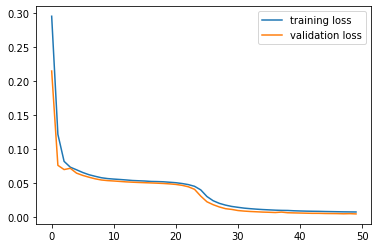

In [11]:
plt.plot(hist['loss'], label='training loss')
plt.plot(hist['val_loss'], label='validation loss')
plt.legend()

# Datasets

Load the first few batches

In [12]:
temp_train = [train_generator[i] for i in tqdm(range(50))]
train_dataset = np.vstack([data[0] for data in temp_train])
train_dataset.shape

bunch_sorted_index: [2 1 0]
group_bunches: [2446. 1864. 1725.]
group_bunches sorted: [1725. 1864. 2446.]
restore_index: [2 1 0]
group_bunches restored: [2446. 1864. 1725.]
bunch_sorted_index: [1 0 2]
group_bunches: [323. 221. 332.]
group_bunches sorted: [221. 323. 332.]
restore_index: [1 0 2]
group_bunches restored: [323. 221. 332.]
bunch_sorted_index: [2 0 1]
group_bunches: [706. 976. 342.]
group_bunches sorted: [342. 706. 976.]
restore_index: [1 2 0]
group_bunches restored: [706. 976. 342.]



(396800, 2048, 2)

In [13]:
train_dataset_meta = pd.concat([meta[1] for meta in temp_train])
train_dataset_meta.shape

(396800, 12)

In [14]:
del temp_train

In [15]:
temp_validation = [validation_generator[i] for i in tqdm(range(5))]
validation_dataset = np.vstack([data[0] for data in temp_validation])
validation_dataset.shape

(39680, 2048, 2)

In [16]:
validation_dataset_meta = pd.concat([meta[1] for meta in temp_validation])
validation_dataset_meta.shape

(39680, 12)

In [17]:
del temp_validation

# Predictions

In [18]:
train_pred = model.predict(train_dataset, verbose=1, batch_size=train_generator.batch_size)
train_pred.shape

50/50 [==============================] - 89s 2s/step


(396800, 2048, 2)

In [19]:
validation_pred = model.predict(validation_dataset, verbose=1, batch_size=validation_generator.batch_size)
validation_pred.shape

5/5 [==============================] - 9s 2s/step


(39680, 2048, 2)

In [20]:
MAE_train = abs(train_pred - train_dataset).mean(axis=(1, 2)).squeeze()
MAE_train.shape

(396800,)

In [21]:
MAE_validation = abs(validation_pred - validation_dataset).mean(axis=(1, 2)).squeeze()
MAE_validation.shape

(39680,)

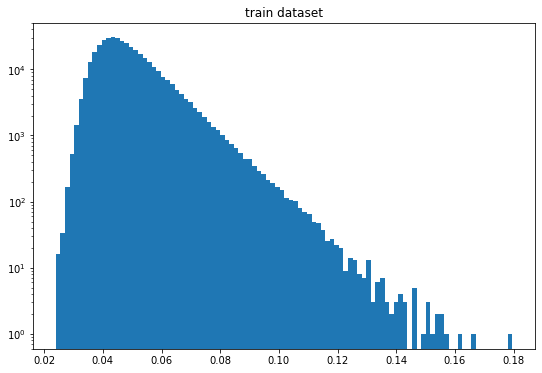

In [22]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_train, bins=100)
plt.title("train dataset")
plt.yscale('log')

rough peak

In [23]:
hist_peak_train = bins[n.argmax()]
hist_peak_train

0.04266973159536244

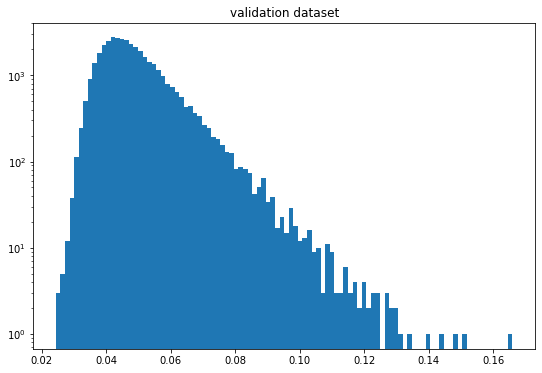

In [24]:
plt.figure(figsize=(9, 6))
n, bins, _ = plt.hist(MAE_validation, bins=100)
plt.title("validation dataset")
plt.yscale('log')

In [25]:
hist_peak_validation = bins[n.argmax()]
hist_peak_validation

0.04132875485895862

In [26]:
max_MAE_indices = np.argsort(MAE_train)[::-1]

In [27]:
max_MAE_indices

array([286148,  40703, 289622, ...,  98605,  85598, 365469])

In [28]:
def plot_true_pred(true_signal, pred_signal):
    fig, axes = plt.subplots(2, figsize=(16, 6))
    axes[0].plot(true_signal[:, 0])
    axes[0].plot(pred_signal[:, 0])

    axes[1].plot(true_signal[:, 1])
    axes[1].plot(pred_signal[:, 1])
#     axes[1].plot(np.abs(np.diff(true_signal)))
#     axes[1].plot(np.abs(np.diff(pred_signal)))
    return fig, axes

from pathlib import Path
from pyobsbox.utils import H5_PLANE_KEY
from pyobsbox import DB
import h5py

db = DB()

def load_plot(filepath: str, bunch_index: int):
    
    file_data = db._extract_columns(filepath)
    beam_key = "B{}".format(file_data["beam"])
    plane_key = H5_PLANE_KEY[file_data["plane"]]
    with h5py.File(filepath, "r") as h5_file:
        ob_data = h5_file[beam_key][plane_key]
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.plot(ob_data[:, bunch_index])

index:  286148
MAE:  0.17957330189140358
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             19
Name: 5070, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


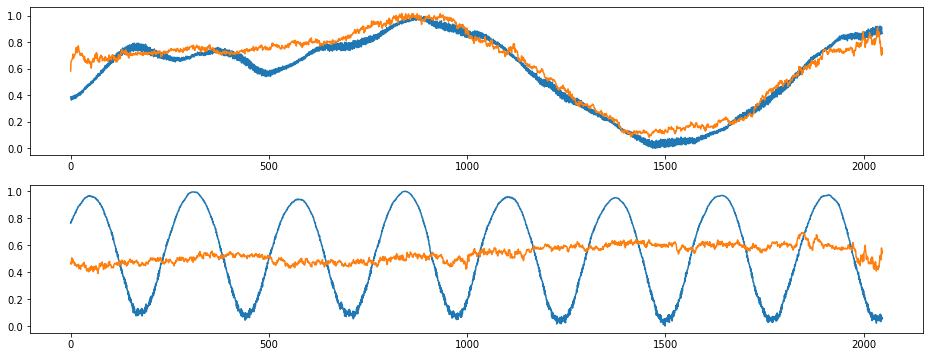

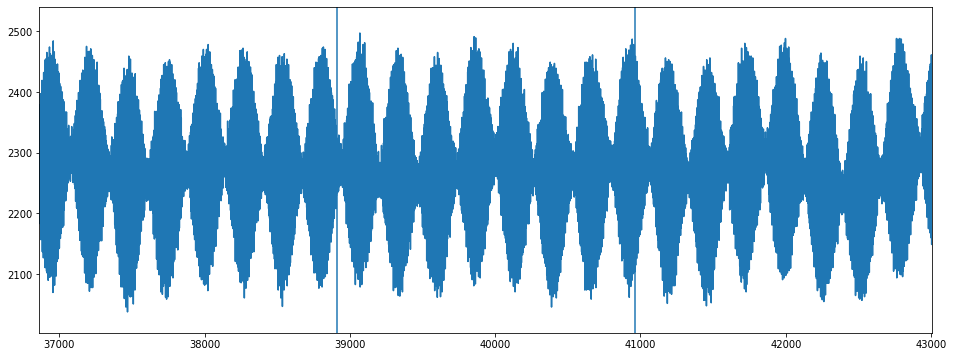

In [37]:
anomalous = 0
anomalous_index = max_MAE_indices[anomalous]

print('index: ', anomalous_index)
print("MAE: ", MAE_train[anomalous_index])
# I'm not sure this row is correct
metadata_row = train_dataset_meta.iloc[anomalous_index]
print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
print(metadata_row['file'])

true_signal = train_dataset[anomalous_index].squeeze()
pred_signal = train_pred[anomalous_index].squeeze()

plot_true_pred(true_signal, pred_signal)
load_plot(metadata_row['file'], metadata_row['bunch_index'])

signal_chunk = metadata_row['chunk']
plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
plt.axvline(true_signal.shape[0]*signal_chunk)
plt.axvline(true_signal.shape[0]*(signal_chunk+1))

# Top rightmost signals

index:  286148
MAE:  0.17957330189140358
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             19
Name: 5070, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


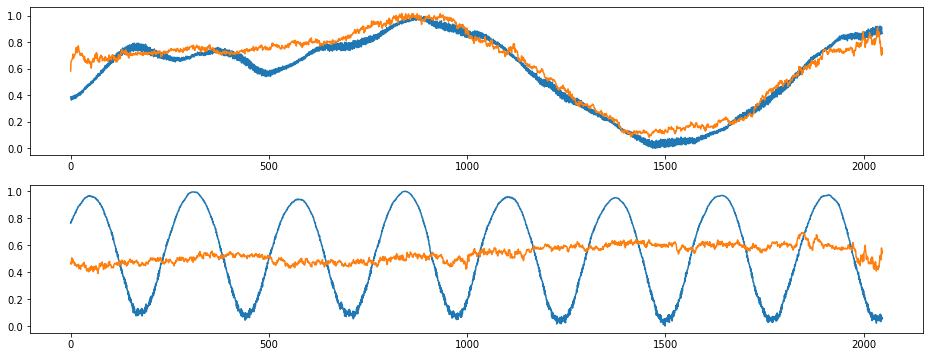

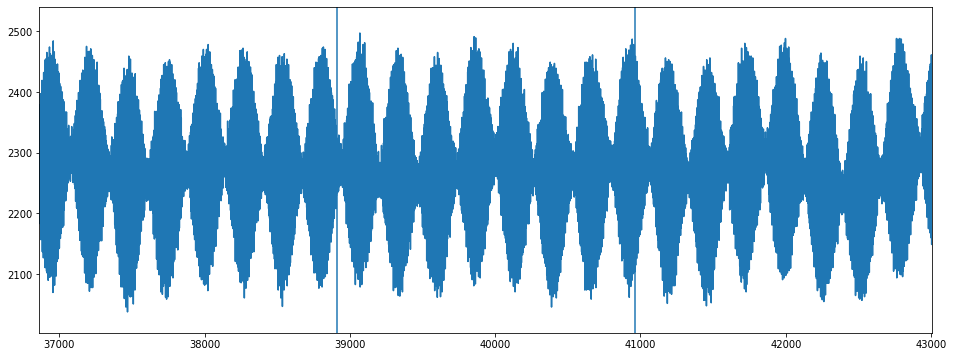

index:  40703
MAE:  0.16665152375476341
n_bunches       612
bunch_index     459
bunch_number     81
chunk            17
Name: 4588, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7452/instability_data/07452_Inst_B1H_Q7_20181117_16h33m14s.h5


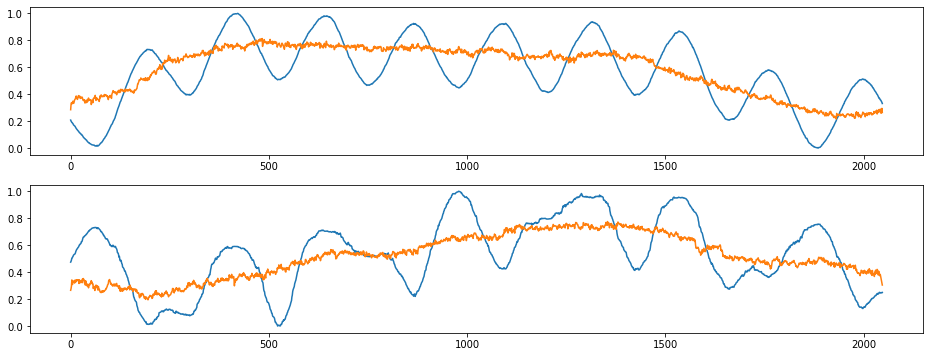

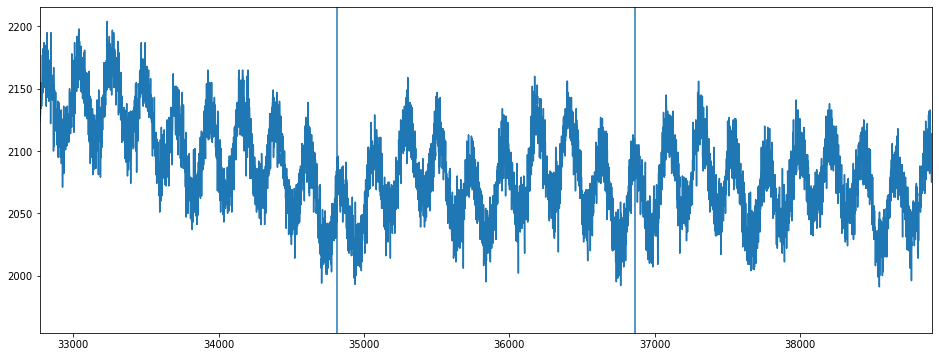

index:  289622
MAE:  0.1614379376755836
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             26
Name: 6862, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


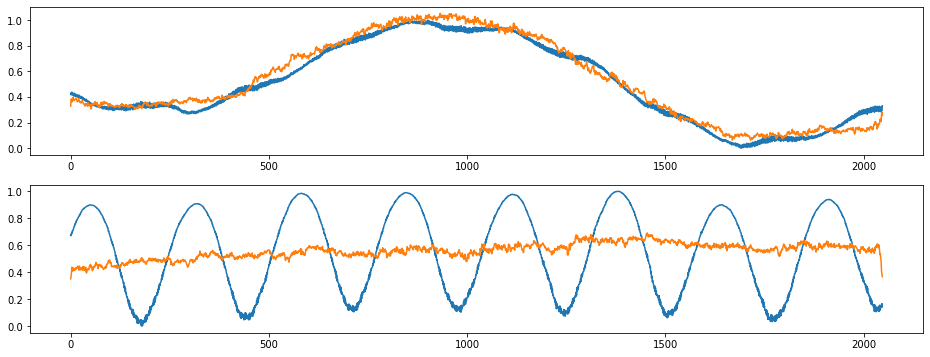

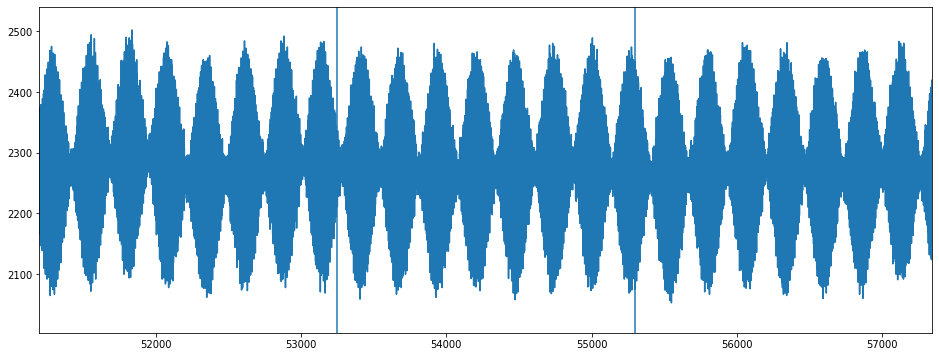

index:  291965
MAE:  0.1568183176992669
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              6
Name: 1742, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


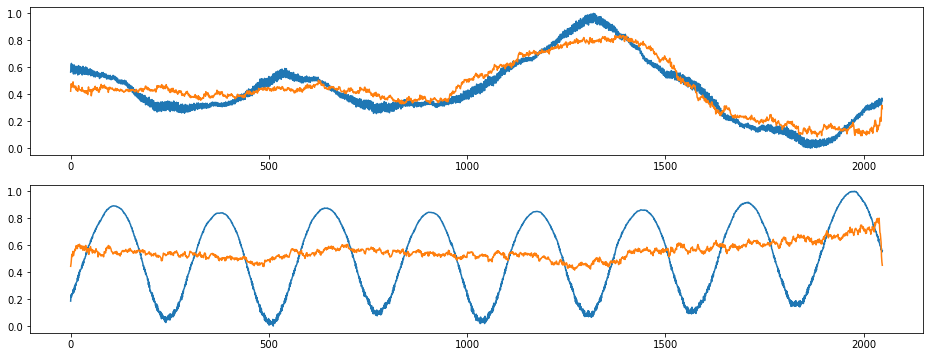

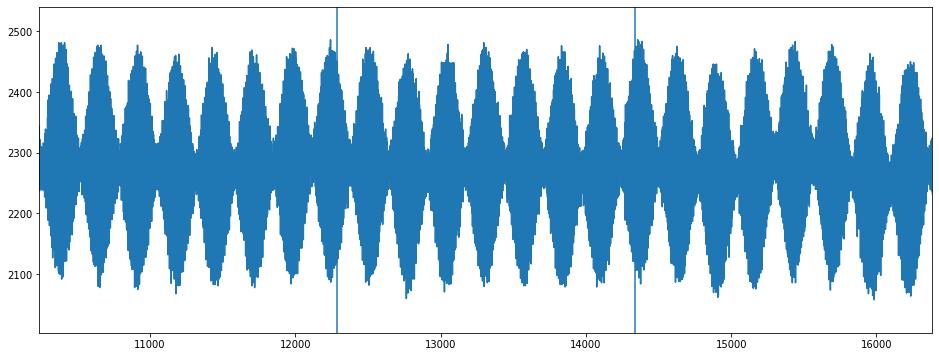

index:  360253
MAE:  0.15604913604434736
n_bunches       732
bunch_index     376
bunch_number    268
chunk            13
Name: 3411, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7157/instability_data/07157_Inst_B1H_Q7_20180913_01h44m58s.h5


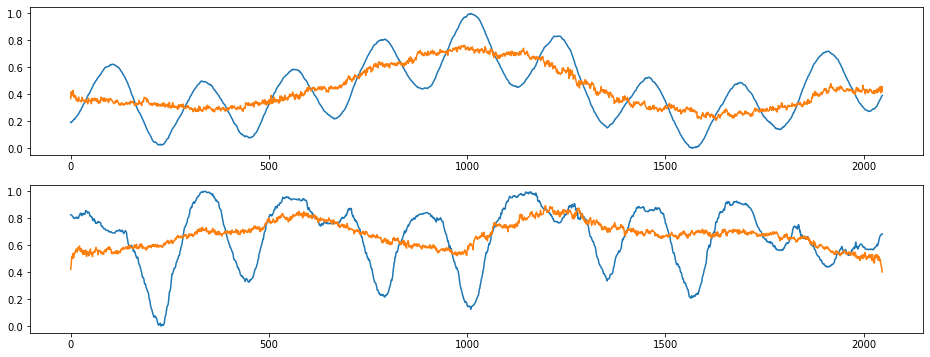

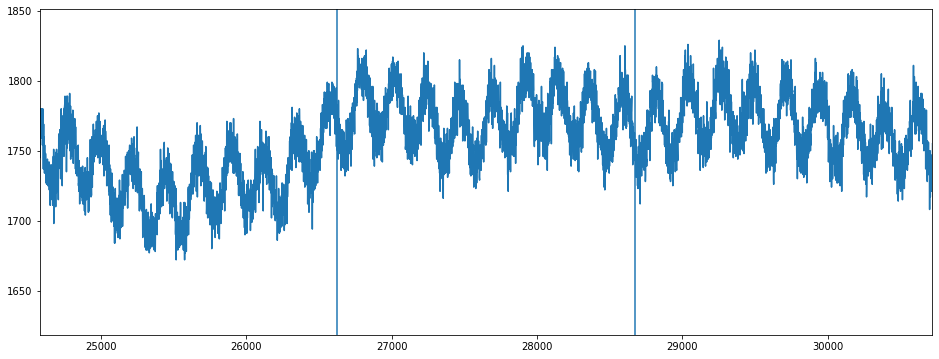

index:  286131
MAE:  0.1554898410190649
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             28
Name: 7374, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


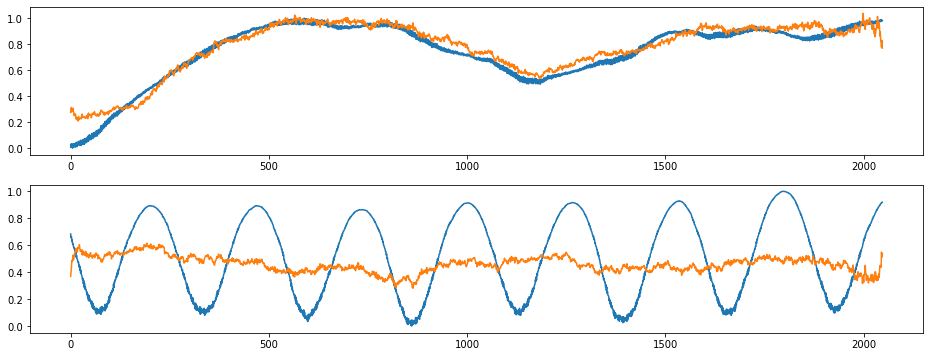

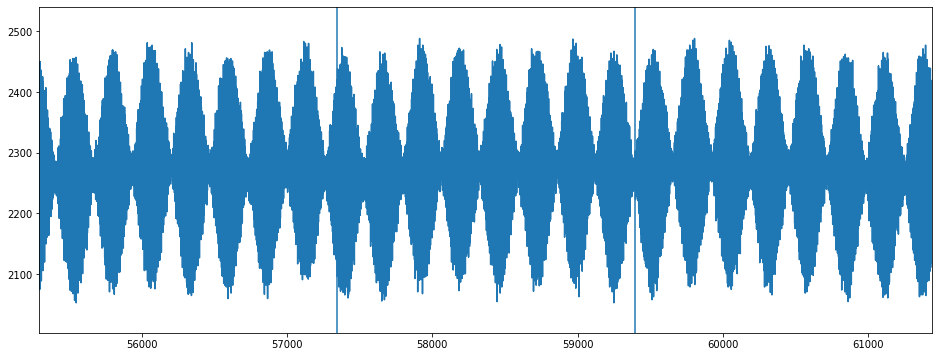

index:  290014
MAE:  0.1537252558619297
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             27
Name: 7118, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


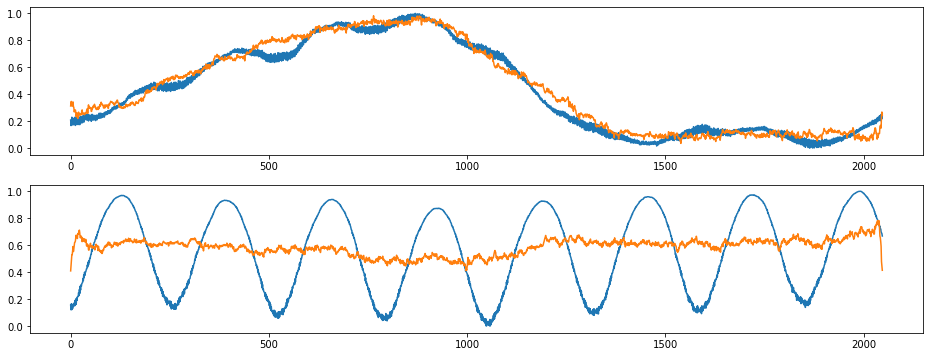

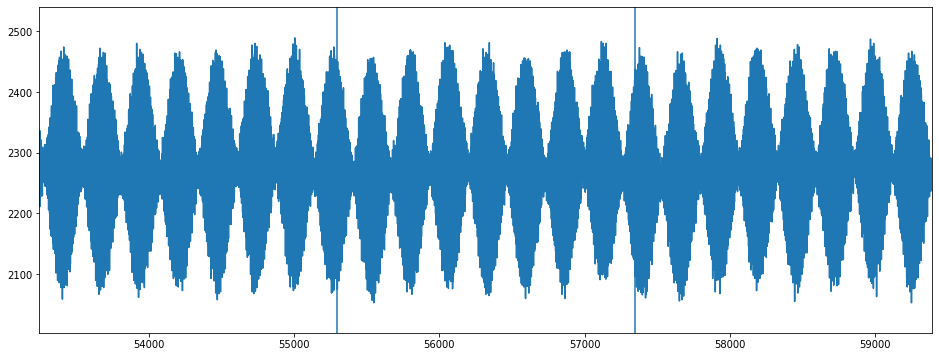

index:  293531
MAE:  0.15366832798388777
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              3
Name: 974, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


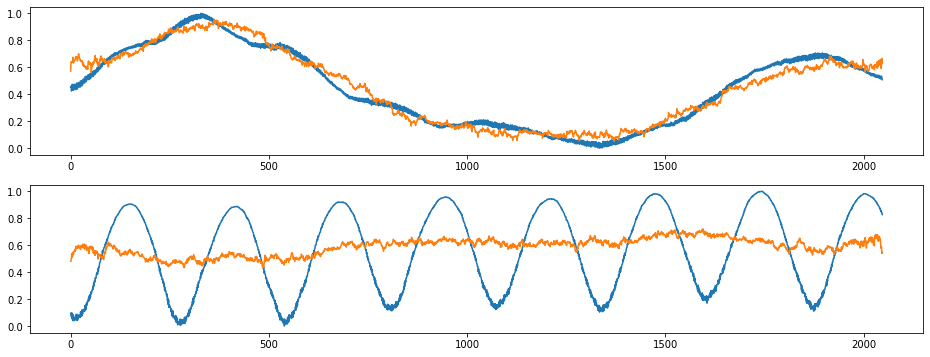

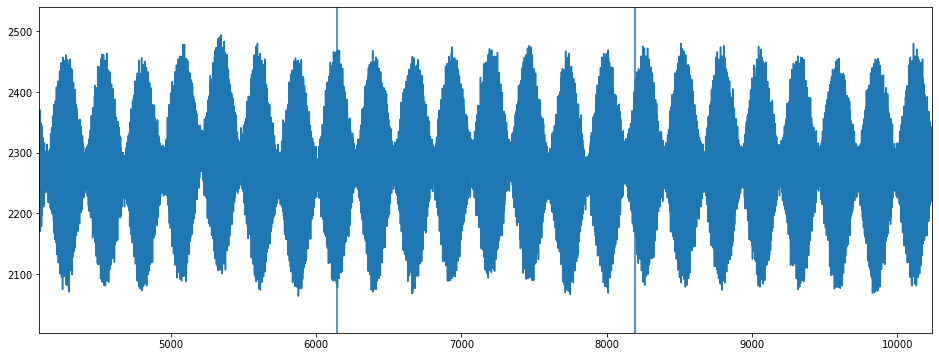

index:  290707
MAE:  0.15280822972119693
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             29
Name: 7630, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


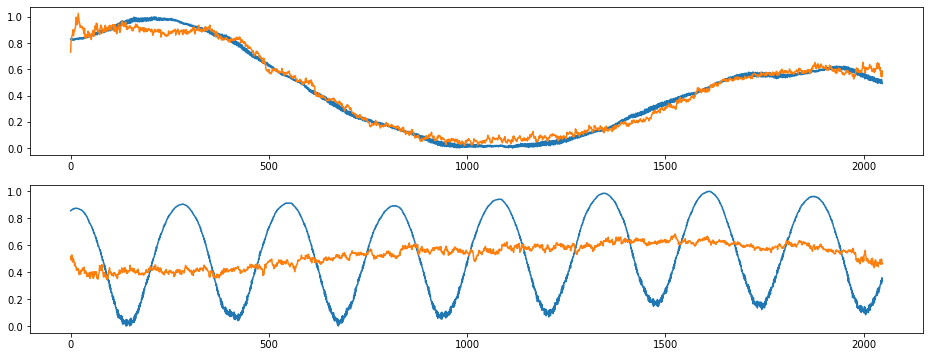

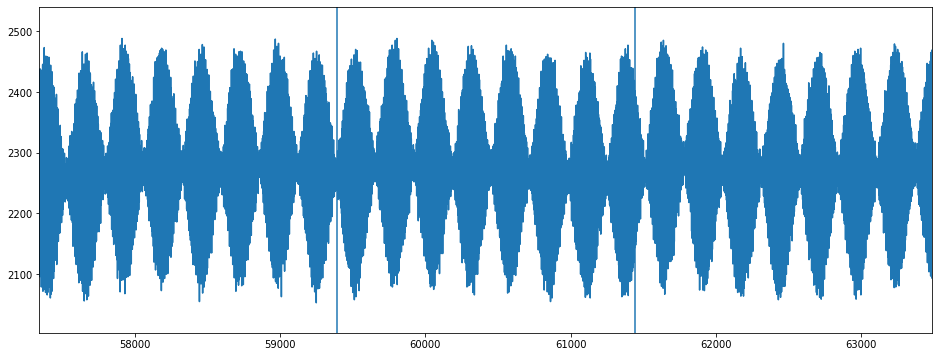

index:  290633
MAE:  0.15147483779999213
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              2
Name: 718, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


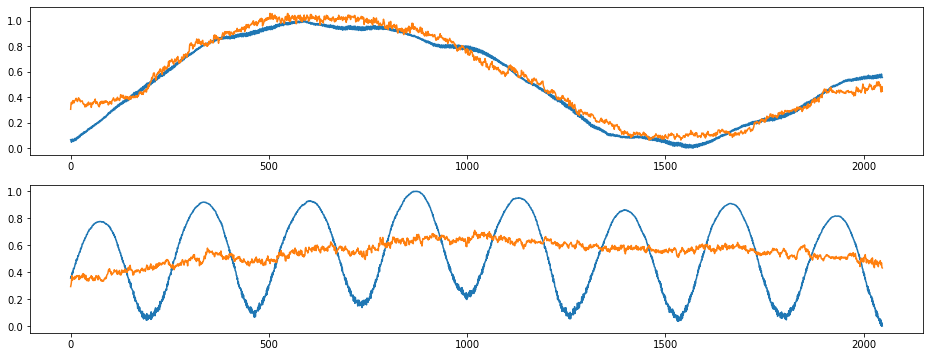

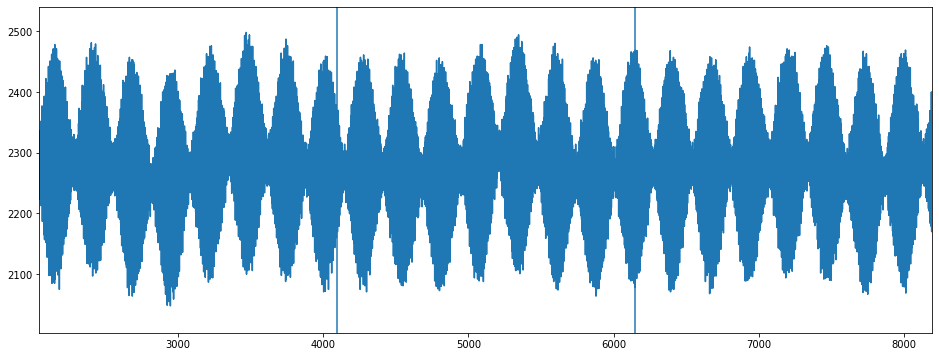

In [38]:
for i in range(10):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.axvline(true_signal.shape[0]*signal_chunk)
    plt.axvline(true_signal.shape[0]*(signal_chunk+1))
    plt.show()

# Top leftmost signals

index:  365469
MAE:  0.024001062918629554
n_bunches       924
bunch_index     642
bunch_number    458
chunk             6
Name: 1765, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7333/instability_data/07333_Inst_B1H_Q7_20181022_22h15m42s.h5


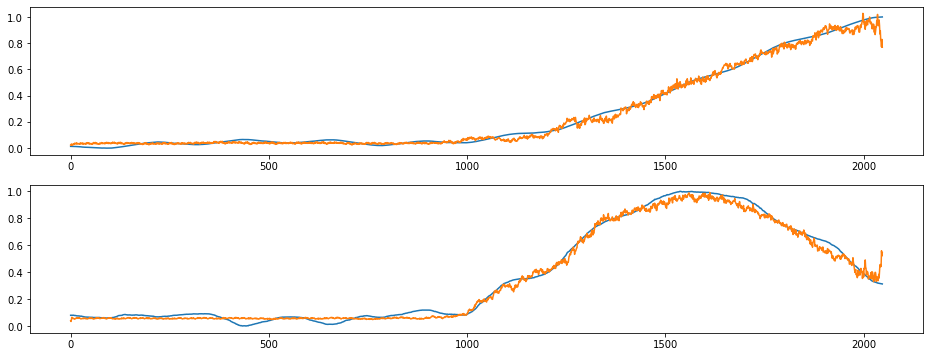

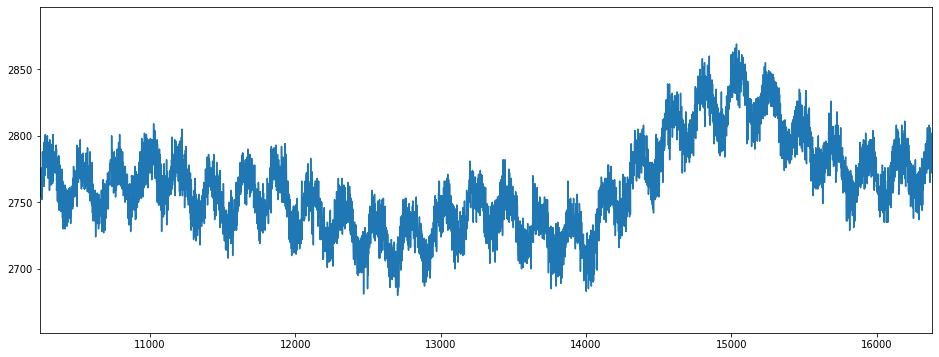

index:  85598
MAE:  0.024159200243194175
n_bunches       302
bunch_index     566
bunch_number    102
chunk            22
Name: 5659, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6880/instability_data/06880_Inst_B1H_Q7_20180703_02h32m40s.h5


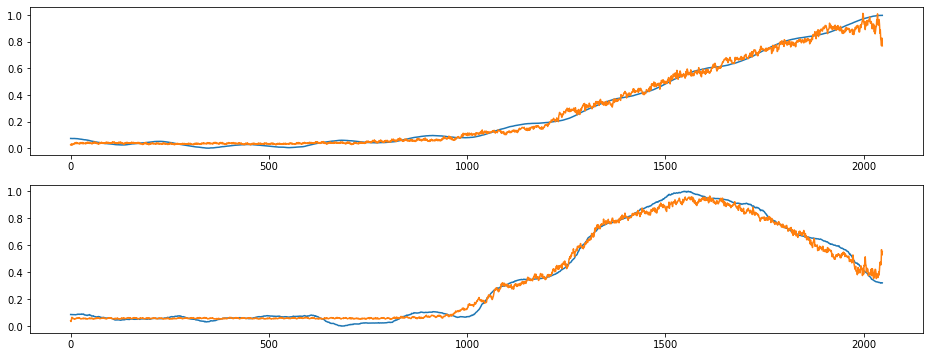

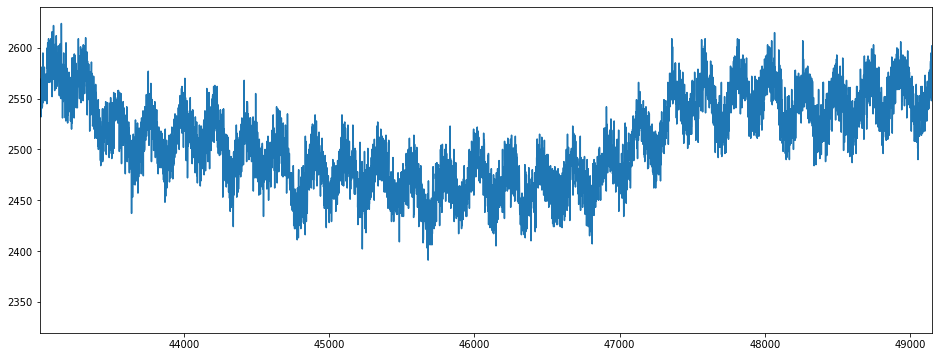

index:  98605
MAE:  0.02435461938056935
n_bunches        313
bunch_index     1176
bunch_number     246
chunk              8
Name: 2151, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7479/instability_data/07479_Inst_B1H_Q7_20181127_21h25m51s.h5


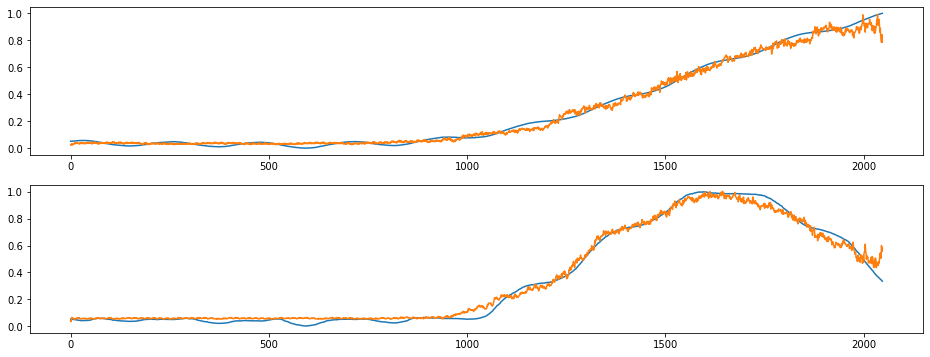

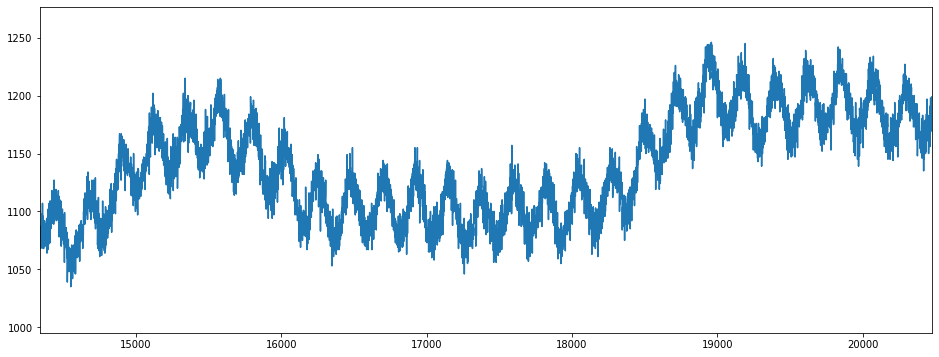

index:  9849
MAE:  0.024652921465647487
n_bunches       252
bunch_index     131
bunch_number     75
chunk            24
Name: 6374, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_05h38m29s.h5


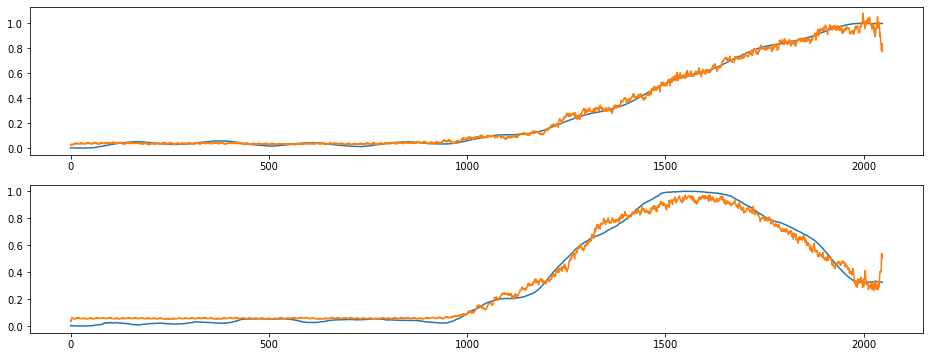

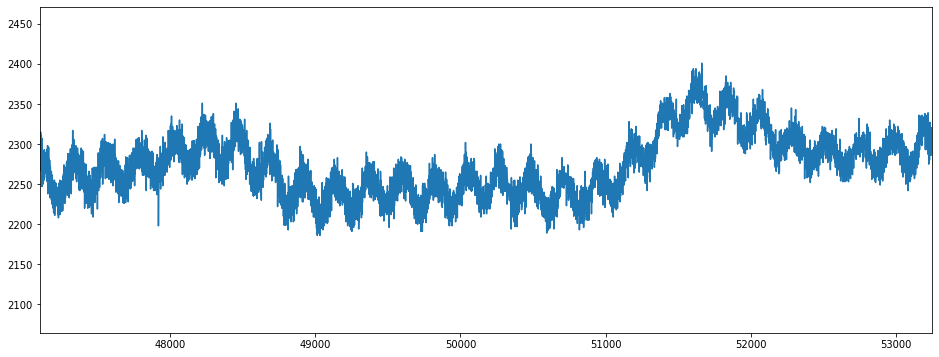

index:  56493
MAE:  0.024759096055908265
n_bunches       540
bunch_index     283
bunch_number    189
chunk             4
Name: 1185, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7110/instability_data/07110_Inst_B1H_Q7_20180831_21h58m48s.h5


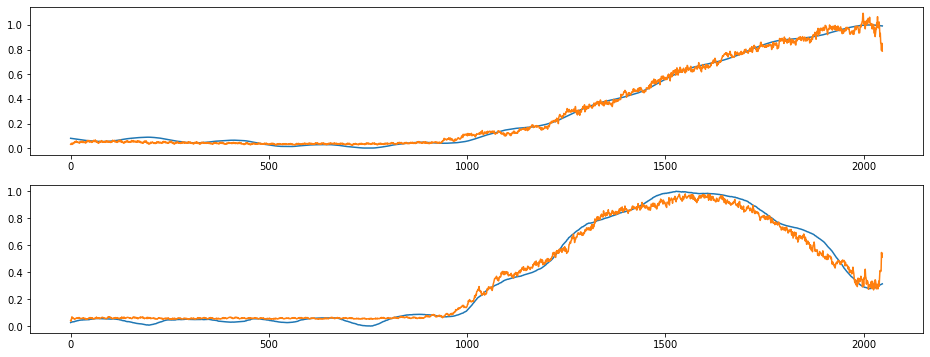

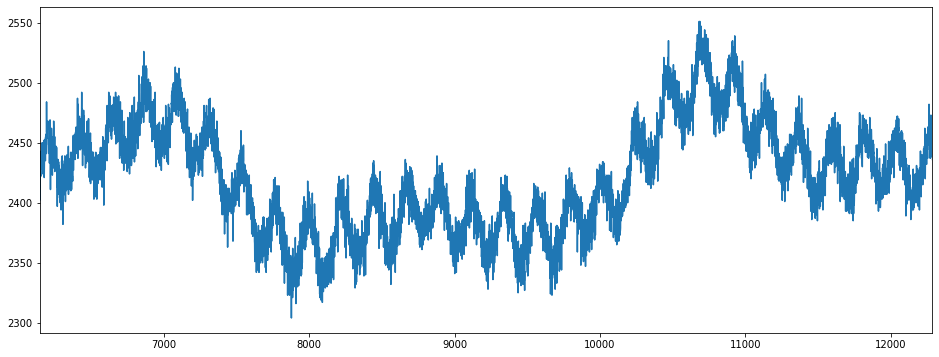

index:  322202
MAE:  0.02479225152156072
n_bunches       1068
bunch_index      450
bunch_number     311
chunk             23
Name: 6065, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7235/instability_data/07235_Inst_B1H_Q7_20180929_17h18m14s.h5


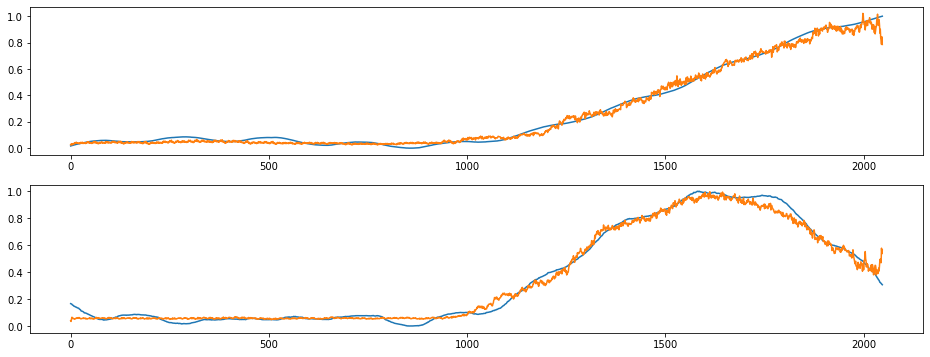

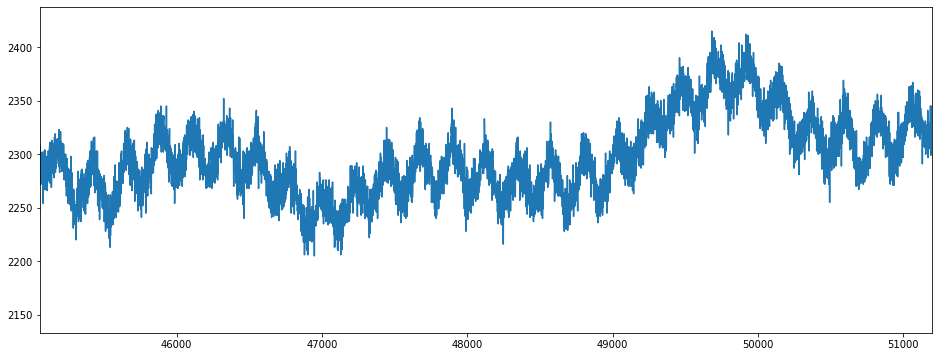

index:  200825
MAE:  0.024805687956858162
n_bunches       924
bunch_index     152
bunch_number     77
chunk            16
Name: 4266, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6746/instability_data/06746_Inst_B1H_Q7_20180531_15h59m47s.h5


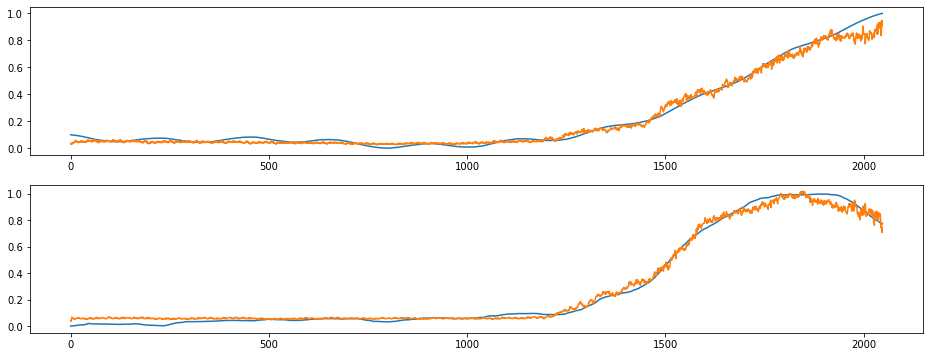

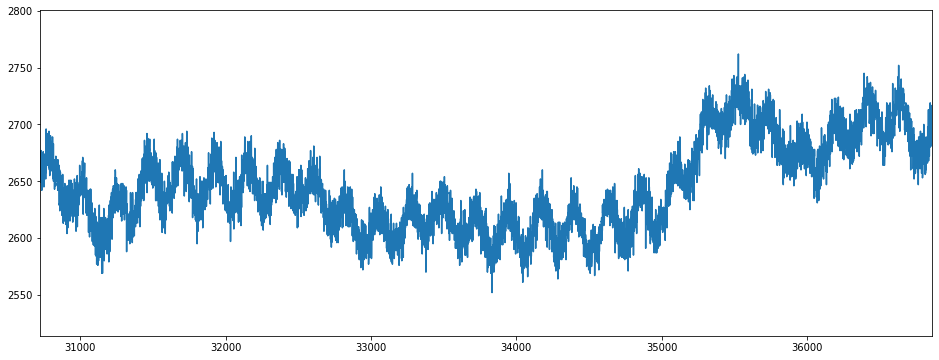

index:  184106
MAE:  0.02485796379448017
n_bunches       252
bunch_index      69
bunch_number     20
chunk            24
Name: 6321, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_05h38m29s.h5


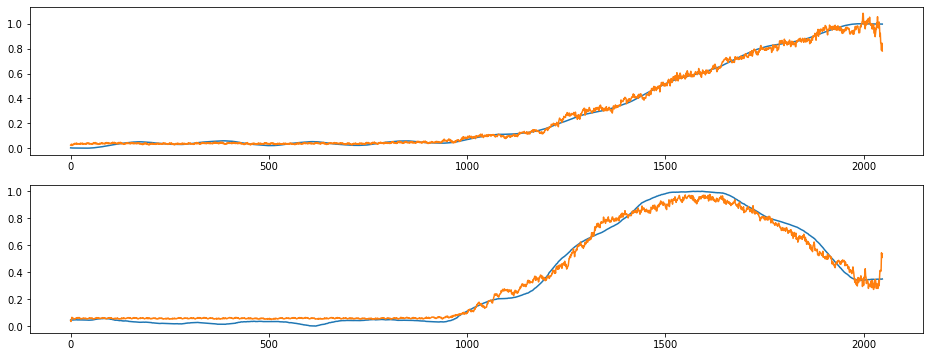

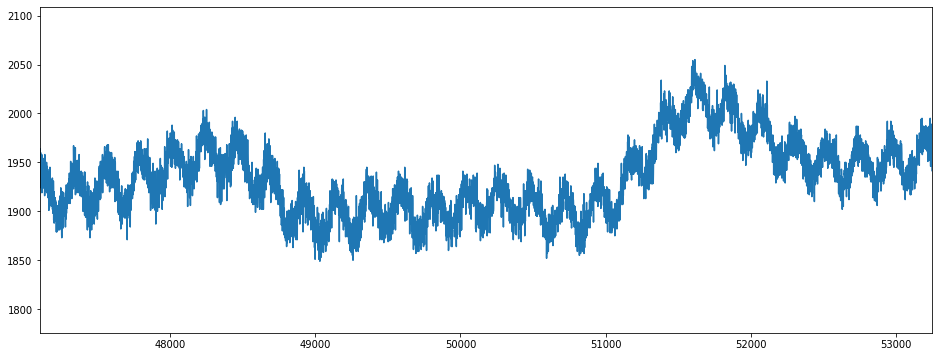

index:  272849
MAE:  0.024943130388374334
n_bunches       2556
bunch_index      293
bunch_number     199
chunk             20
Name: 5205, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7017/instability_data/07017_Inst_B1H_Q7_20180803_22h21m00s.h5


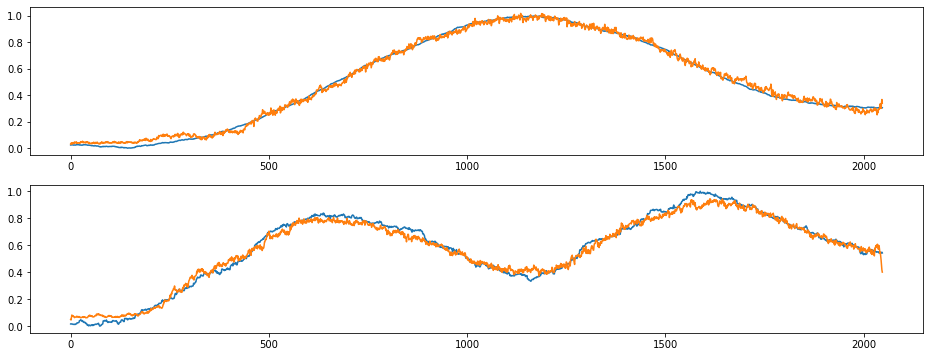

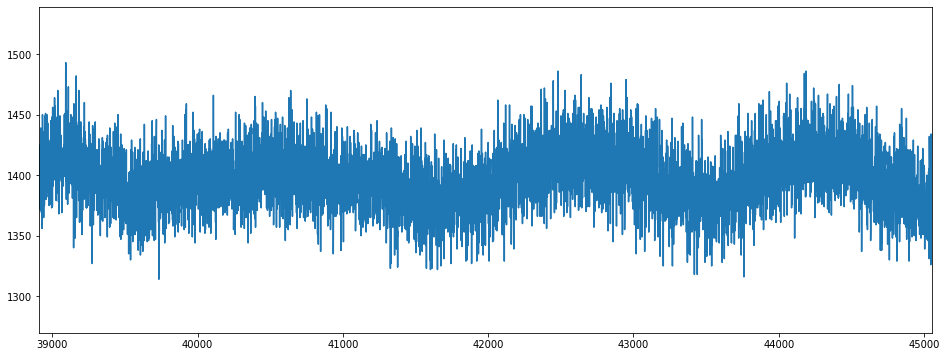

index:  189520
MAE:  0.02533104321925233
n_bunches       924
bunch_index     271
bunch_number    177
chunk            14
Name: 3623, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7108/instability_data/07108_Inst_B1H_Q7_20180831_04h53m42s.h5


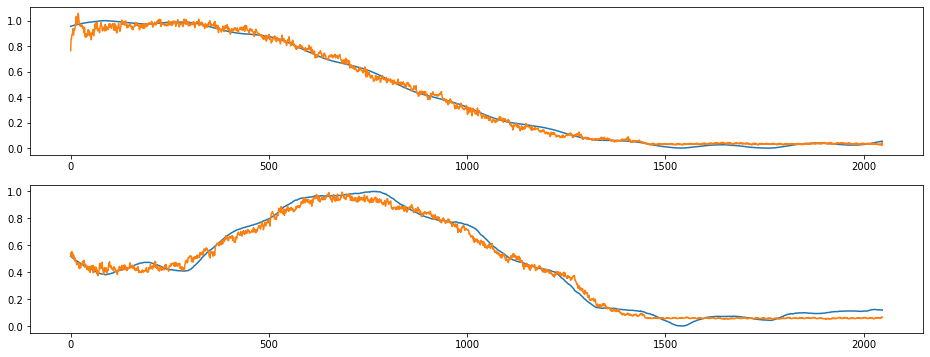

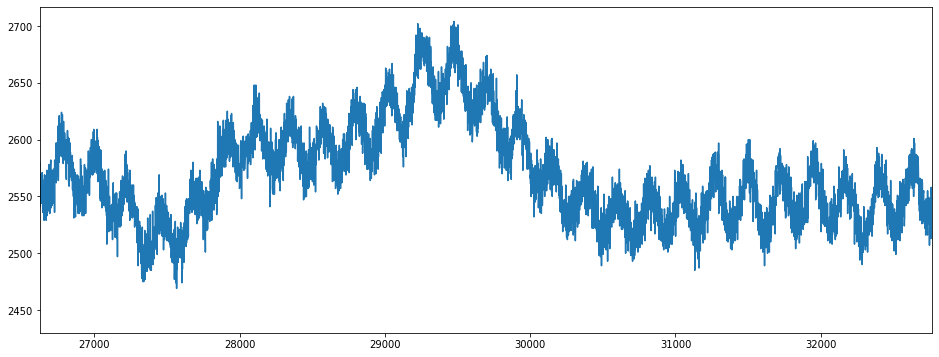

In [40]:
for i in range(1, 11):
    left_most = -i
    anomalous_index = max_MAE_indices[left_most]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.axvline(true_signal.shape[0]*signal_chunk)
    plt.axvline(true_signal.shape[0]*(signal_chunk+1))
    plt.show()

# Signals around the peak

In [41]:
around_peak_indices = np.argsort(np.abs(MAE_train - hist_peak_train))

index:  110452
MAE:  0.04266970656193268
n_bunches       108
bunch_index     117
bunch_number     49
chunk             2
Name: 529, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6744/instability_data/06744_Inst_B1H_Q7_20180531_03h30m15s.h5


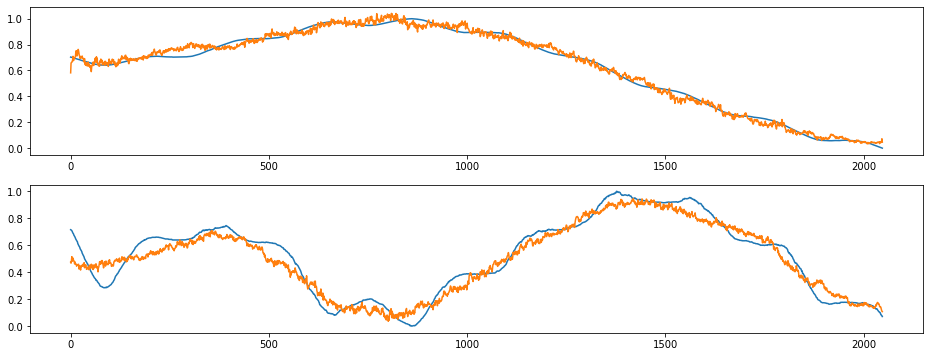

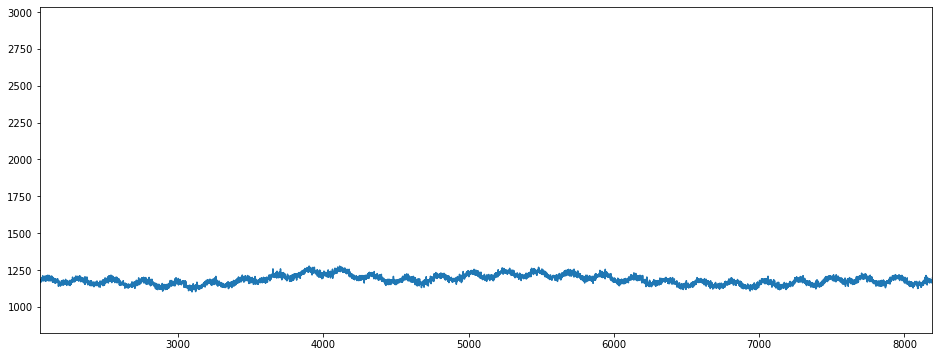

index:  72933
MAE:  0.04266970223798746
n_bunches       780
bunch_index     141
bunch_number     85
chunk            30
Name: 7822, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7047/instability_data/07047_Inst_B1H_Q7_20180812_15h33m14s.h5


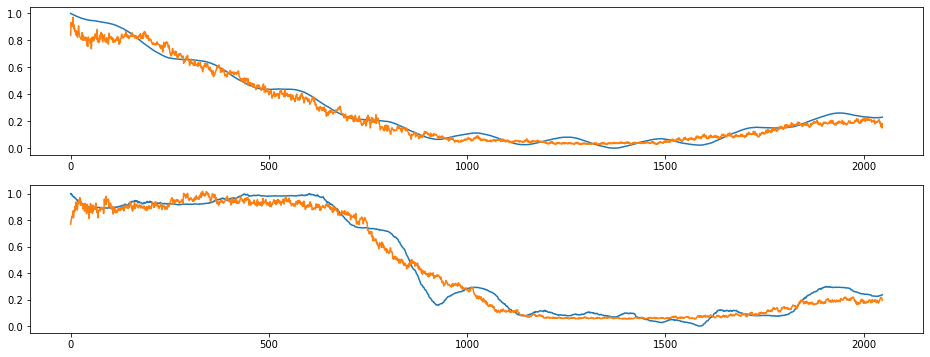

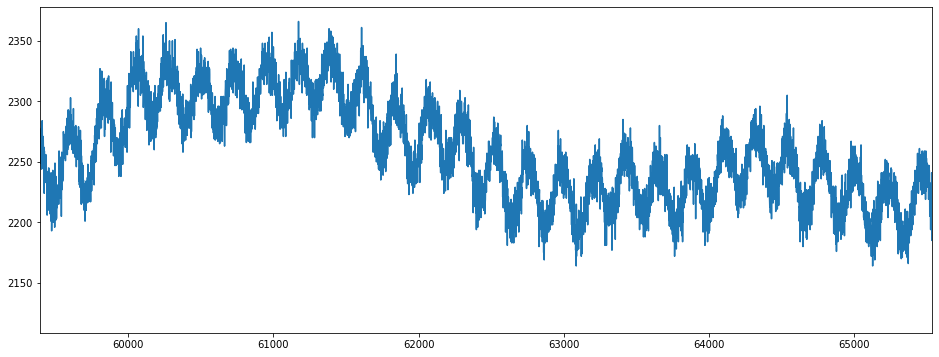

index:  27132
MAE:  0.042669810754873555
n_bunches       2556
bunch_index      480
bunch_number     341
chunk              1
Name: 463, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6919/instability_data/06919_Inst_B1H_Q7_20180713_13h51m14s.h5


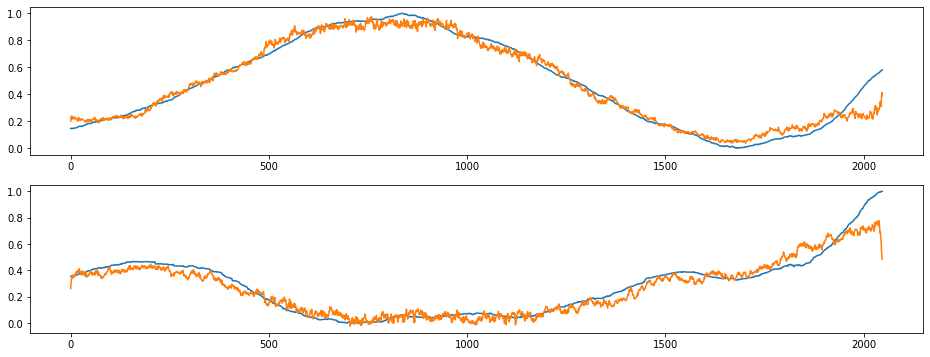

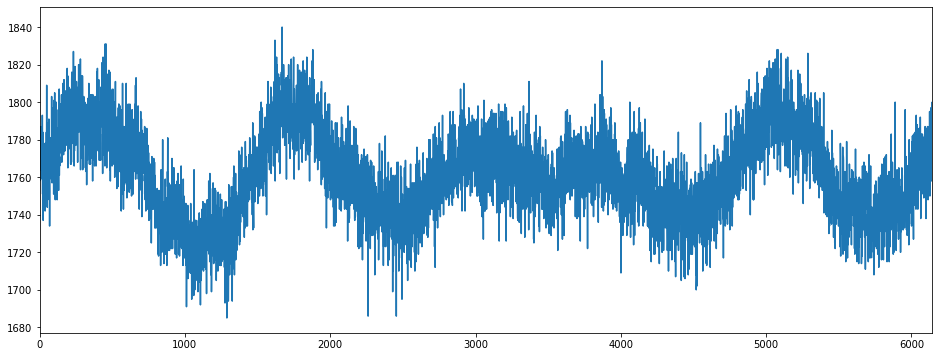

index:  336926
MAE:  0.04266982078680128
n_bunches        602
bunch_index     1394
bunch_number     412
chunk             10
Name: 2587, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6688/instability_data/06688_Inst_B1H_Q7_20180515_18h18m01s.h5


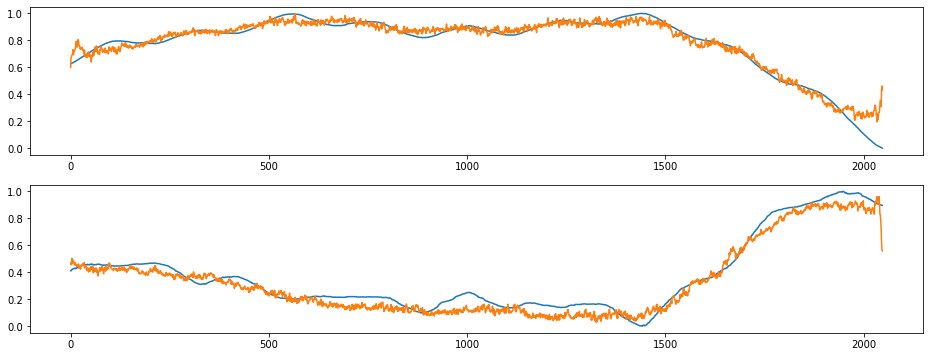

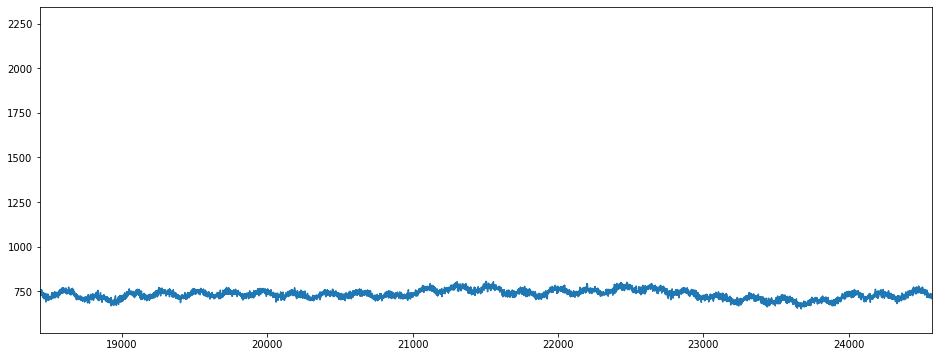

index:  332530
MAE:  0.04266960900220963
n_bunches        156
bunch_index     2332
bunch_number      92
chunk             28
Name: 7310, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6200/instability_data/06200_Inst_B1H_Q7_20170914_23h37m30s.h5


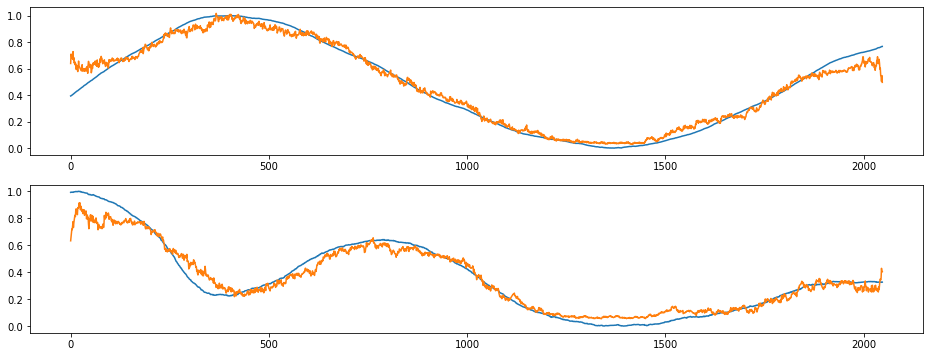

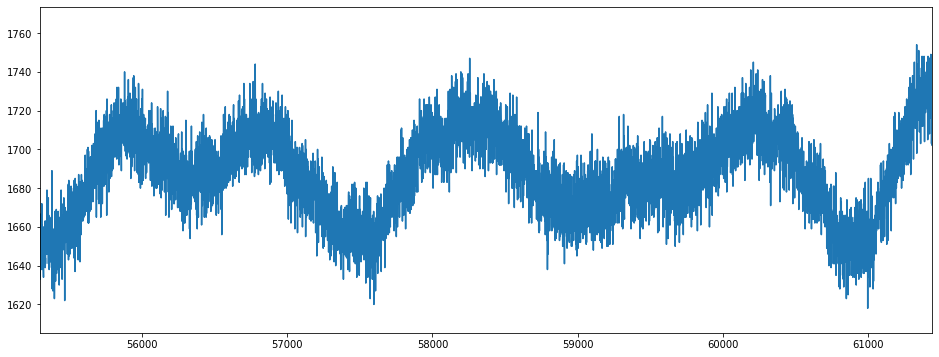

index:  74143
MAE:  0.0426696004044696
n_bunches        648
bunch_index     2039
bunch_number     378
chunk             30
Name: 7808, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7483/instability_data/07483_Inst_B1H_Q7_20181129_10h14m16s.h5


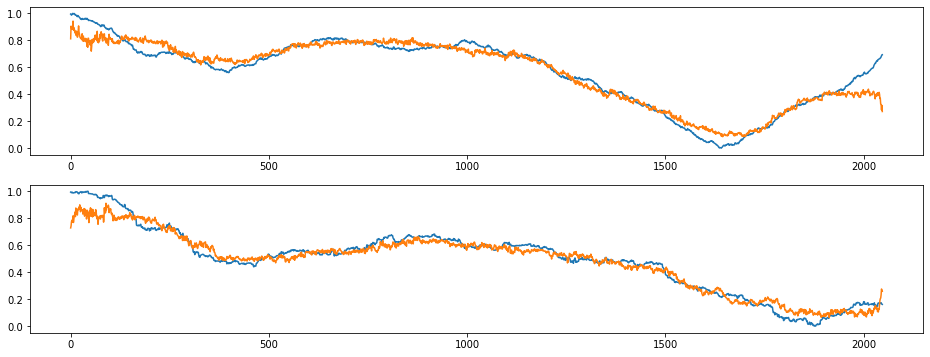

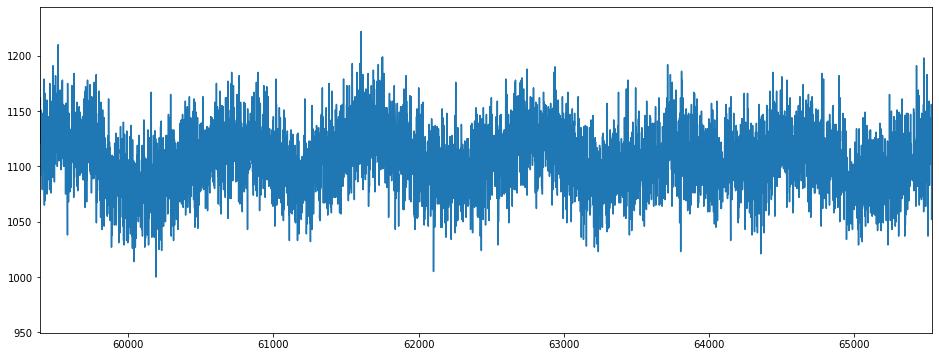

index:  52073
MAE:  0.04266988818102273
n_bunches       2556
bunch_index     2854
bunch_number    2113
chunk             16
Name: 4224, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6663/instability_data/06663_Inst_B1H_Q7_20180510_15h13m15s.h5


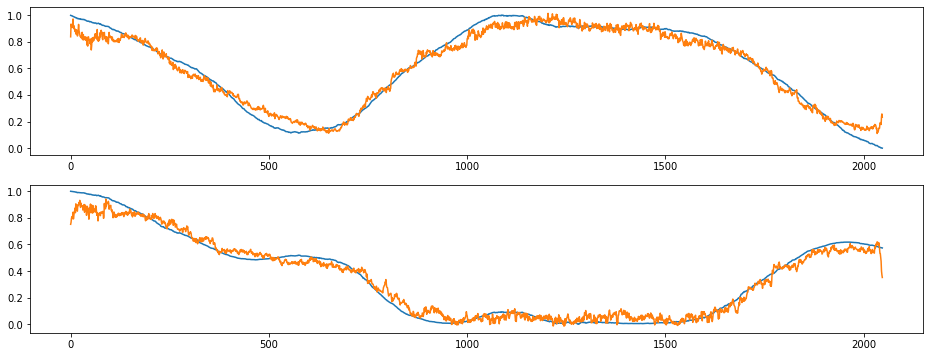

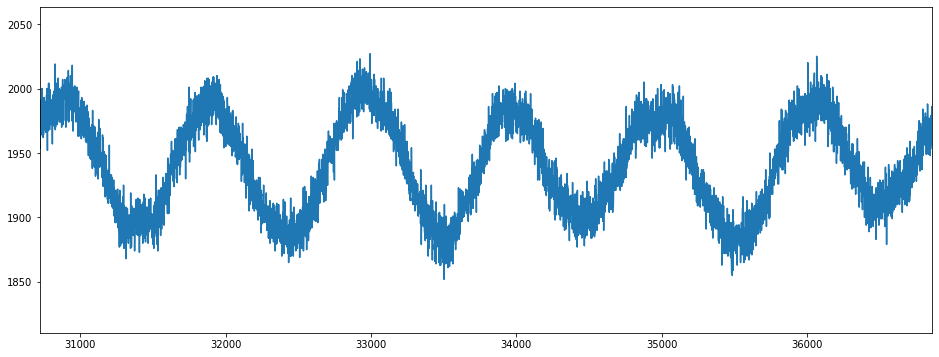

index:  116444
MAE:  0.042669550605806794
n_bunches       2556
bunch_index     3259
bunch_number    2416
chunk             15
Name: 3948, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7033/instability_data/07033_Inst_B1H_Q7_20180807_11h36m14s.h5


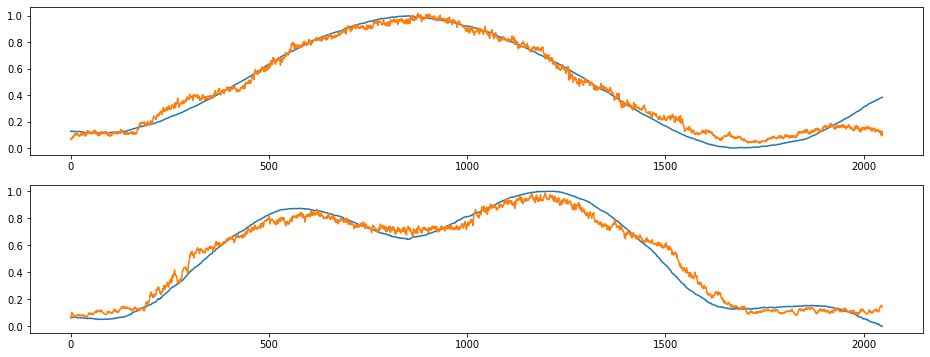

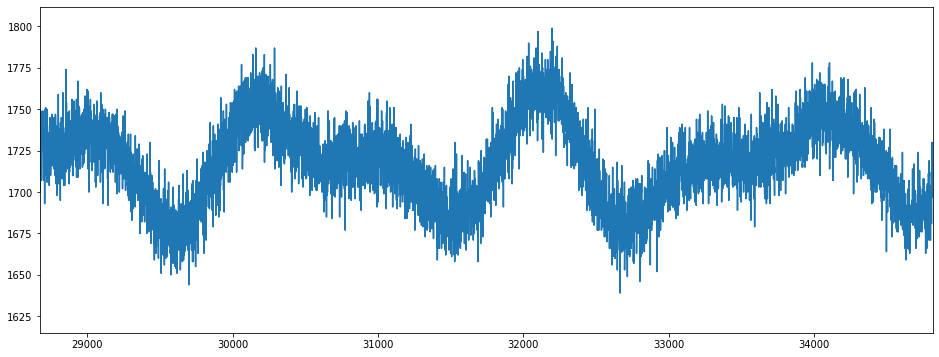

index:  29338
MAE:  0.04266954233393512
n_bunches       1292
bunch_index     2172
bunch_number     771
chunk             14
Name: 3777, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6396/instability_data/06396_Inst_B1H_Q7_20171117_15h25m13s.h5


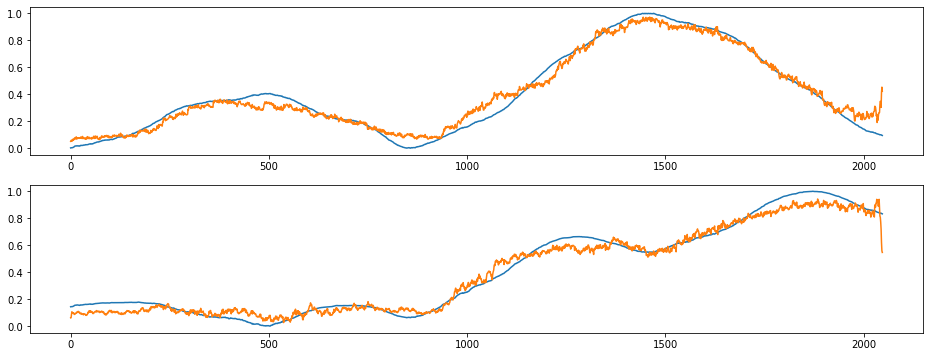

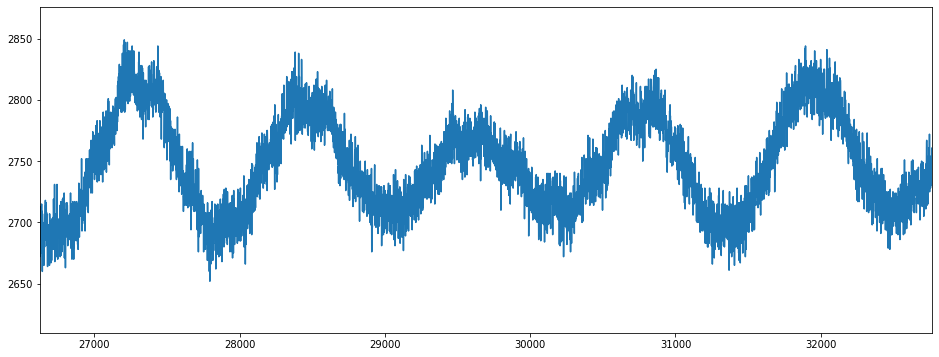

index:  70331
MAE:  0.04266998008088372
n_bunches        603
bunch_index     2133
bunch_number     372
chunk             20
Name: 5216, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7308/instability_data/07308_Inst_B1H_Q7_20181016_11h32m14s.h5


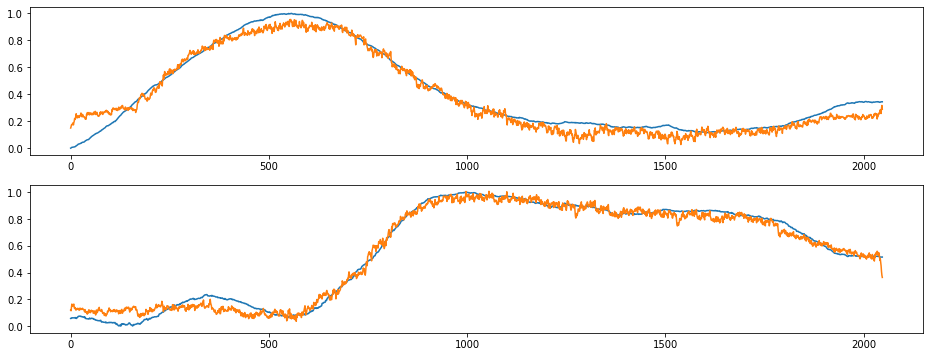

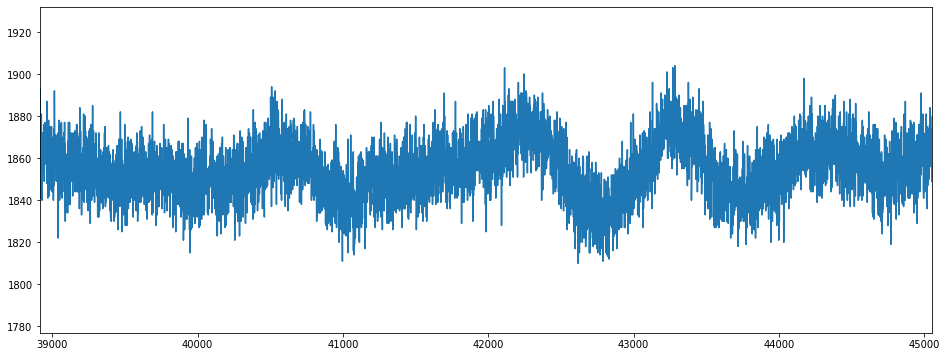

In [42]:
for i in range(10):
    anomalous_index = around_peak_indices[i]

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[anomalous_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

# around a point

In [34]:
around_point_indices = np.argsort(np.abs(MAE_train - 6))

index:  286148
MAE:  0.17957330189140358
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             19
Name: 5070, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


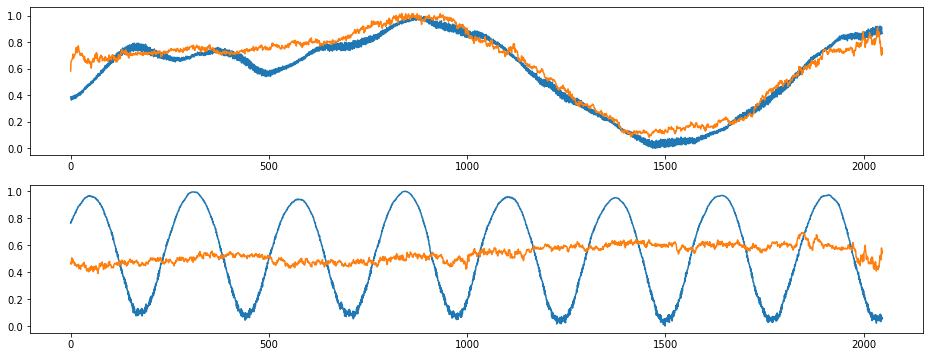

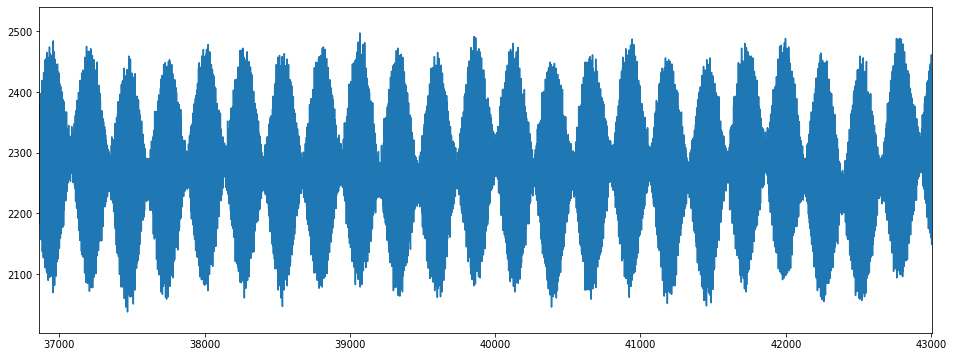

index:  40703
MAE:  0.16665152375476341
n_bunches       612
bunch_index     459
bunch_number     81
chunk            17
Name: 4588, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7452/instability_data/07452_Inst_B1H_Q7_20181117_16h33m14s.h5


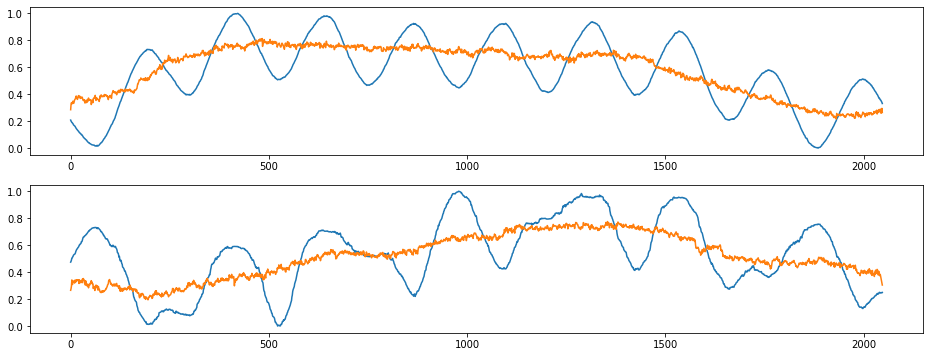

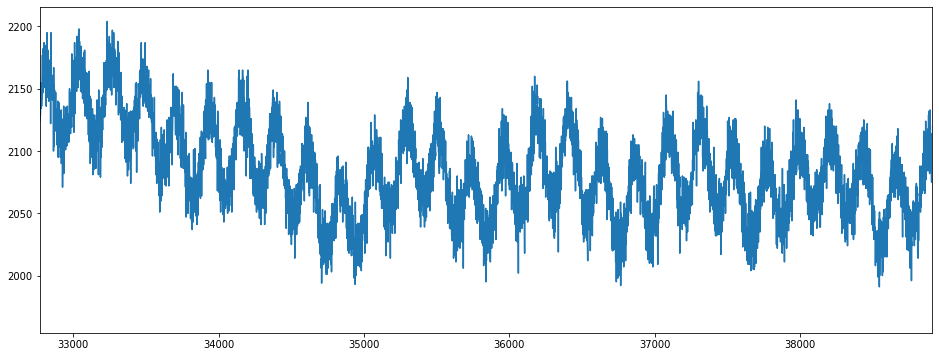

index:  289622
MAE:  0.1614379376755836
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             26
Name: 6862, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


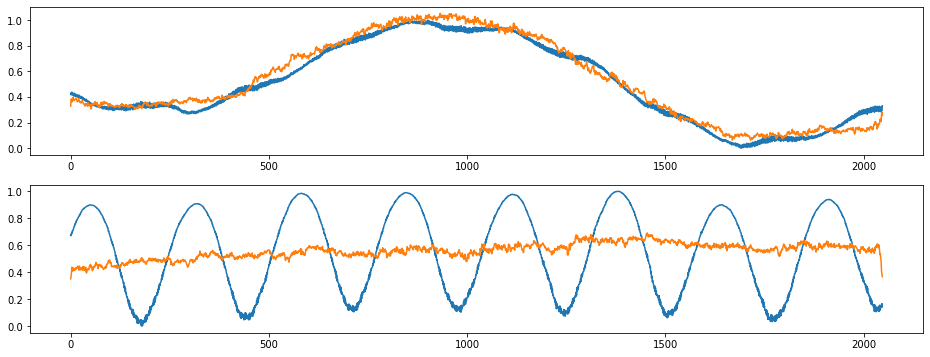

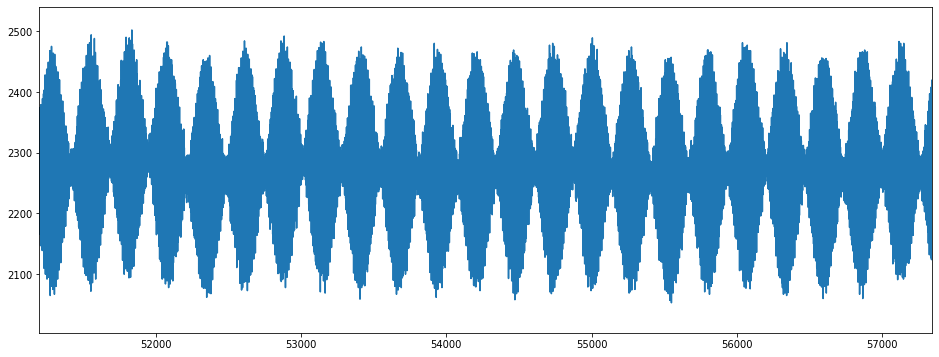

index:  291965
MAE:  0.1568183176992669
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              6
Name: 1742, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


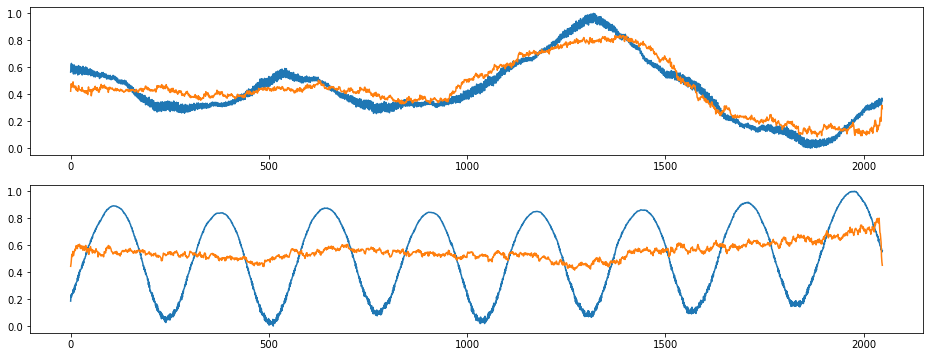

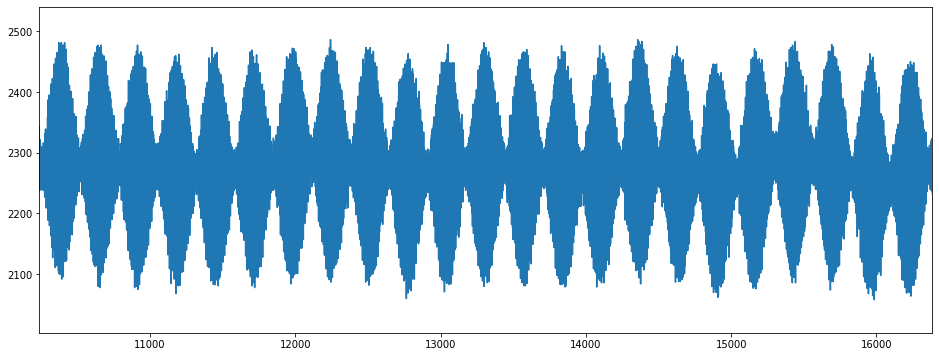

index:  360253
MAE:  0.15604913604434736
n_bunches       732
bunch_index     376
bunch_number    268
chunk            13
Name: 3411, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/7157/instability_data/07157_Inst_B1H_Q7_20180913_01h44m58s.h5


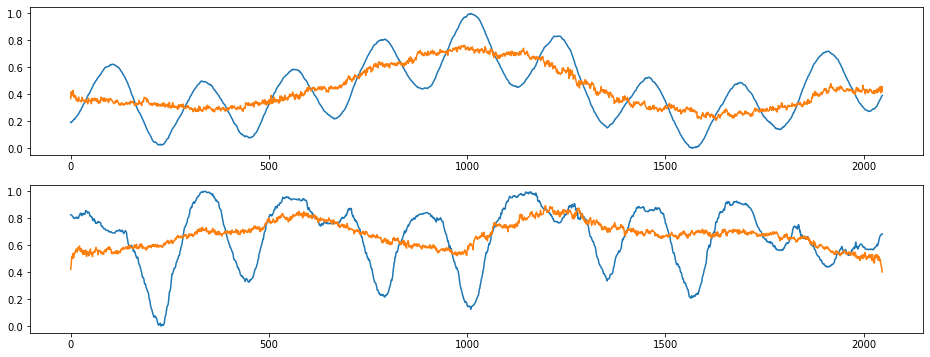

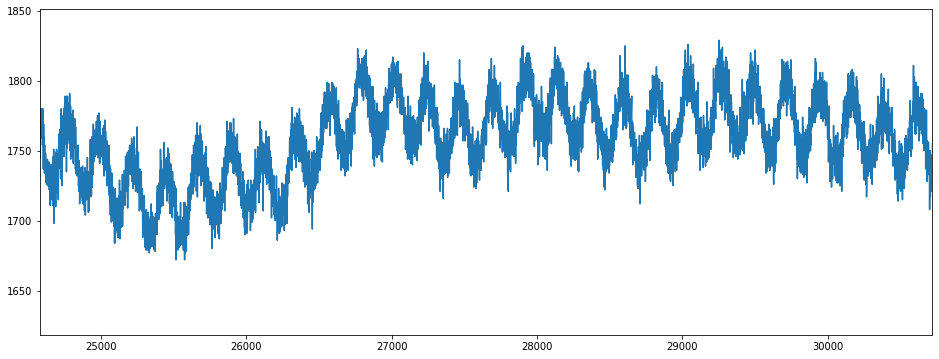

index:  286131
MAE:  0.1554898410190649
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             28
Name: 7374, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


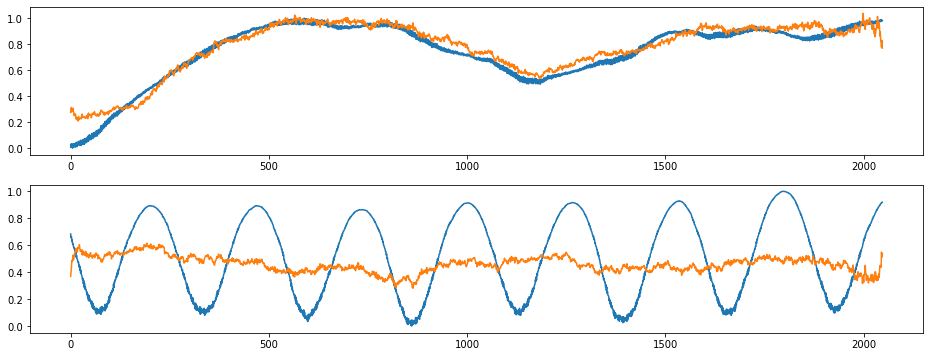

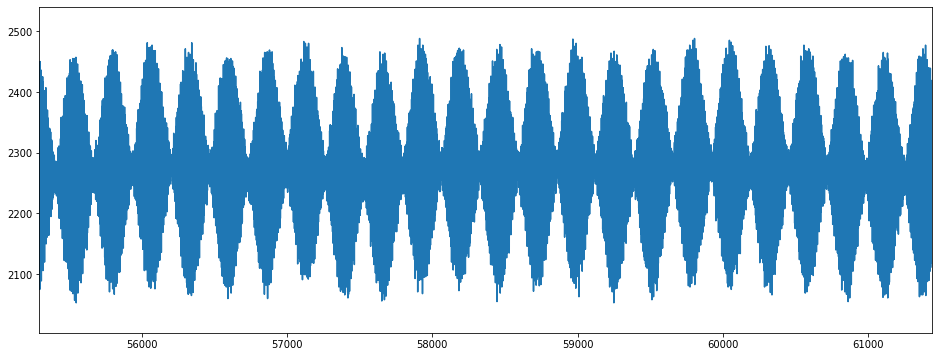

index:  290014
MAE:  0.1537252558619297
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             27
Name: 7118, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


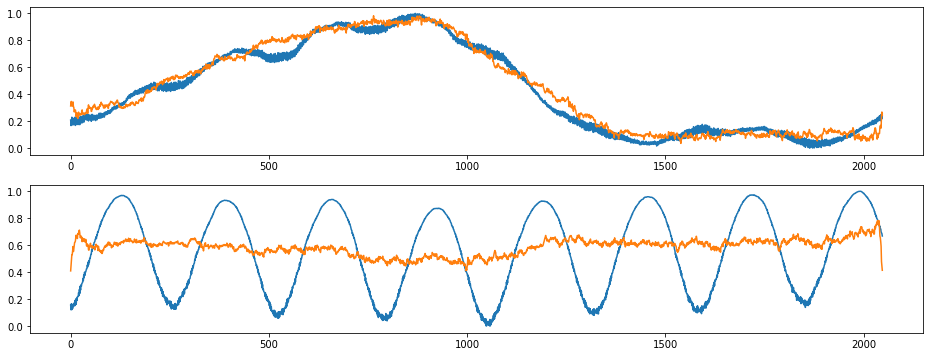

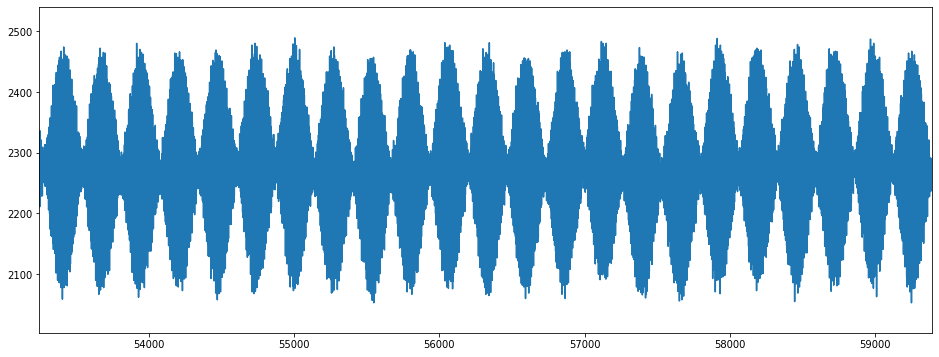

index:  293531
MAE:  0.15366832798388777
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              3
Name: 974, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


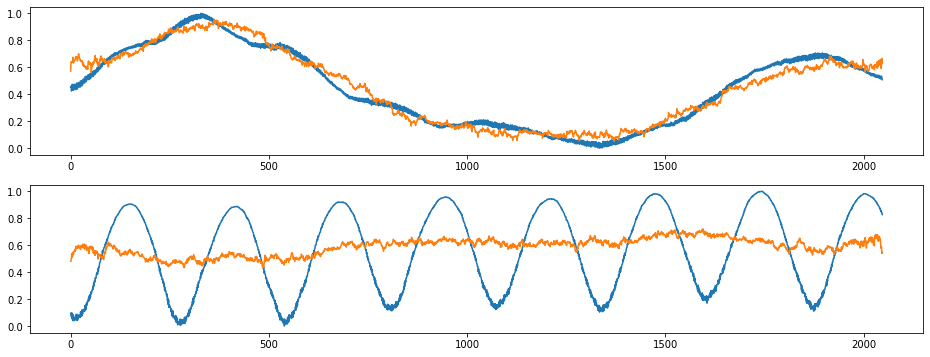

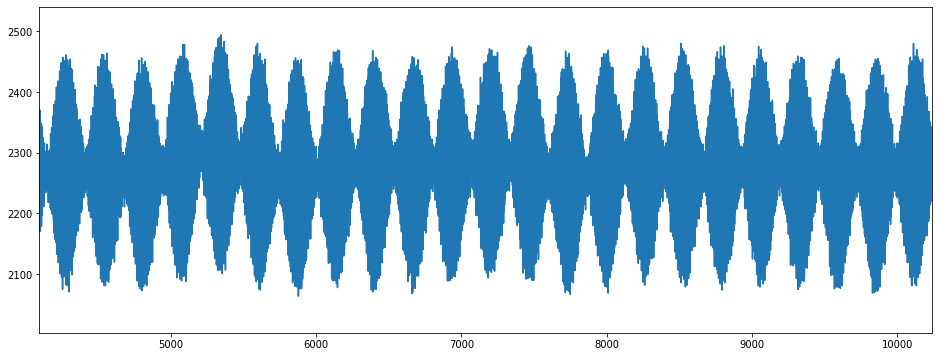

index:  290707
MAE:  0.15280822972119693
n_bunches        129
bunch_index     1520
bunch_number      71
chunk             29
Name: 7630, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


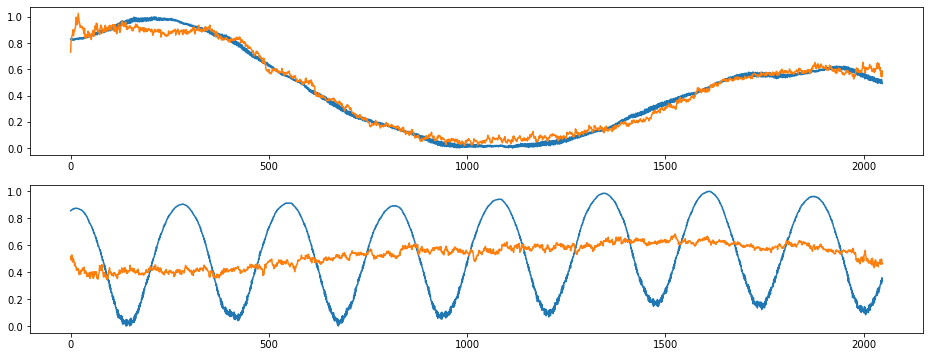

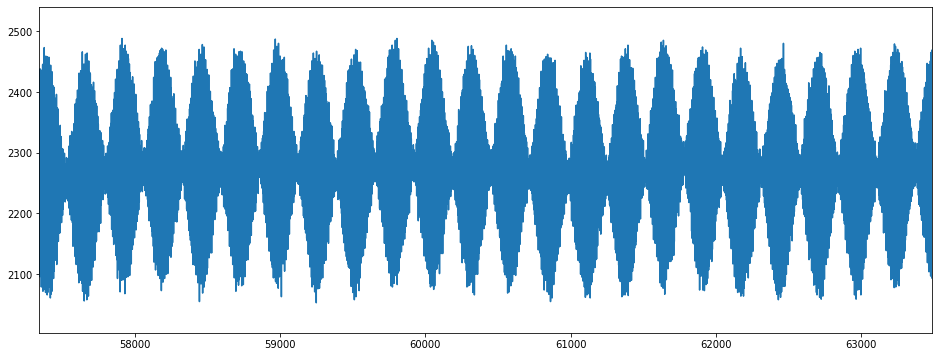

index:  290633
MAE:  0.15147483779999213
n_bunches        129
bunch_index     1520
bunch_number      71
chunk              2
Name: 718, dtype: object
/nfs/cs-ccr-adtobsnfs/lhc_adtobsbox_data/6451/instability_data/06451_Inst_B1H_Q7_20171202_22h50m17s.h5


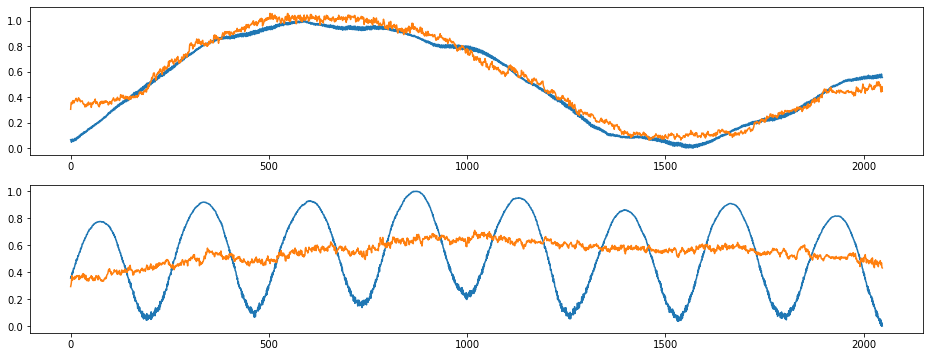

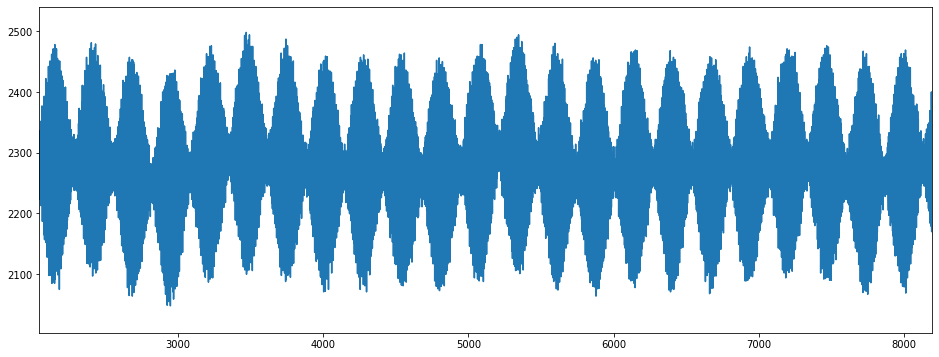

In [35]:
for i in range(10):
    around_point_index = around_point_indices[i]

    print('index: ', around_point_index)
    print("MAE: ", MAE_train[around_point_index])
    # I'm not sure this row is correct
    metadata_row = train_dataset_meta.iloc[around_point_index]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number', 'chunk']])
    print(metadata_row['file'])

    true_signal = train_dataset[around_point_index].squeeze()
    pred_signal = train_pred[around_point_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    load_plot(metadata_row['file'], metadata_row['bunch_index'])

    signal_chunk = metadata_row['chunk']
    plt.xlim([true_signal.shape[0]*(signal_chunk-1), true_signal.shape[0]*(signal_chunk+2)])
    plt.show()

In [36]:
break

SyntaxError: 'break' outside loop (<ipython-input-36-6aaf1f276005>, line 4)

# latent space encoding

In [ ]:
import keras

In [ ]:
encoding_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer('conv1d_3').output)

In [ ]:
encoding_output = encoding_model(train_dataset[max_MAE_indices[-1]][None, :])
encoding_output.shape

In [ ]:
plt.imshow(np.array(encoding_output).squeeze())

# Latent space encoding of nominal signals

In [ ]:
for i in range(1, 11):
    left_most = -i
    left_most_index = max_MAE_indices[left_most]
    
    encoding_output = encoding_model(train_dataset[max_MAE_indices[left_most]][None, :])

    print('index: ', left_most_index)
    print("MAE: ", MAE_train[left_most_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[left_most_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])


    true_signal = train_dataset[left_most_index].squeeze()
    pred_signal = train_pred[left_most_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Latent space encoding of anomalous signals

In [ ]:
for i in range(50):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    
    encoding_output = encoding_model(train_dataset[anomalous_index][None, :])

    print('index: ', anomalous_index)
    print("MAE: ", MAE_train[anomalous_index])
    # I'm not sure this row is correct
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    print(metadata_row[['n_bunches', 'bunch_index', 'bunch_number']])
    print(metadata_row['file'])

    true_signal = train_dataset[anomalous_index].squeeze()
    pred_signal = train_pred[anomalous_index].squeeze()

    plot_true_pred(true_signal, pred_signal)
    plt.show()
    plt.imshow(np.array(encoding_output).squeeze())
    plt.show()

# Generating an latent space image dataset

In [ ]:
latent_dataset = []
latent_metadata = []
latent_input_data = []
for i in tqdm(range(65536)):
    anomalous = i
    anomalous_index = max_MAE_indices[anomalous]
    input_data = train_dataset[anomalous_index][None, :]
    encoding_output = encoding_model(input_data)
    latent_dataset.append(encoding_output)
    latent_input_data.append(input_data)
    # get the metadata
    metadata_row = train_generator.metadata.iloc[anomalous_index // 32]
    latent_metadata.append(metadata_row)
#     break

latent_dataset = np.vstack(latent_dataset)
latent_input_data = np.vstack(latent_input_data)
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
latent_metadata = pd.DataFrame(latent_metadata)

In [ ]:
model_latent_space_folder = latent_space_folder / model_path.name
model_latent_space_file = model_latent_space_folder / f'latent_space_{latent_dataset.shape[0]}.npy'
model_latent_space_metadata_file = model_latent_space_folder / f'metadata_latent_space_{latent_dataset.shape[0]}.h5'
model_train_dataset_file = model_latent_space_folder / f'train_dataset_{train_dataset.shape[0]}.npy'
model_latent_input_file = model_latent_space_folder/ f"latent_input_{latent_input_data.shape[0]}.npy"
model_train_max_MAE_file = model_latent_space_folder / f'train_max_MAE_{max_MAE_indices.shape[0]}.npy'

In [ ]:
if not model_latent_space_folder.is_dir():
    model_latent_space_folder.mkdir()

In [ ]:
np.save(model_latent_space_file, latent_dataset)

In [ ]:
latent_metadata.to_hdf(model_latent_space_metadata_file, 'data')

In [ ]:
np.save(model_train_dataset_file, train_dataset)

In [ ]:
np.save(model_train_max_MAE_file, max_MAE_indices)

In [ ]:
np.save(model_latent_input_file, latent_input_data)